# Vlasov Equation Solver:

In this notebook, we walk through the Vlasov-Poisson equation Solver. 

The unknown field in the Vlasov-Poisson equations is a strictly nonnegative scalar field of three variables $f(x,v,t)$, known as the distribution function. Physically, $f$ gives the phase-space particle density. For convience, we assume the  domain is periodic, so our computational domain is a quotient of $D = [-1,1]^2$. Realistically then, one should assume that $f(x,|v| > 1) = 0$. 

The basic form of the Vlasov equation is $\partial_{t} f + \{f,H\} =0$ where $\{,\}$ is a Poisson bracket and $H$ is some Hamiltonian. To be more explicit, the Vlasov equation is a special type of advection equation given in quasi-linear form by 
$$ $$$$
\frac{\partial f}{\partial t} + \frac{\partial H}{\partial v} \frac{\partial f}{\partial x} - \frac{\partial H}{\partial x}\frac{\partial f}{\partial v} = 0.
$$
$$$$
Typically, $H$ depends on $f$, but it convient to allow for a perscribed $H$ for testing. For example, if $H = v^2/2$ then the vlasov equation reads
$$ $$$$
\partial_{t} f + v \partial_{x} f = 0 
$$
$$$$
which we know the solution to be $f(x,v,t) = f(x-vt,v,t)$. This is essentially just a 1 parameter family of constant-advection equations.
One can show that for any functional of $f$, say $F[f]$, that 
$$
\frac{d}{dt} \int_{D} F[f] = 0.
$$
Importantly, we have that $N = \int f$ is constant. This implies the total number of particles is invariant. One can also show if $H$ is time independant that 
$$ $$$$
\frac{d}{dt} \int_{D} H f = 0.
$$
This is the conservation of energy. It is very difficult if not impossible to make a stable solver for the Vlasov equation that is not at least somewhat diffusive. This is physically ok, since particles are realistically expected to diffuse in momentum space. We should, however, try to keep $f$ positive and for $N$ to be invariant
$$$$
To be more focused, we will always assume $H(x,v) = K(v) - U(x)$. Then the Vlasov equation in conservative form is 
$$ $$ $$
\frac{\partial f}{\partial t} + \frac{\partial}{\partial x}( \frac{\partial K}{\partial v} f) + \frac{\partial}{\partial v}(\frac{\partial U}{\partial x}f) = 0
$$
$$$$
Since this equation is a scalar equation of conservation laws, it is trivially hyperbolic. 

In order to integrate the Vlasov equation, we break $D$ into cells with corners at $(x_{i}, v_{j}) = (i \Delta x, j \Delta v)$. We then represent $f$ in a finite volume sense. To this end, we define 
$$$$
$$
f_{i+1/2,j+1/2}(t) = \frac{1}{\Delta x \Delta v} \int_{x_{i}}^{x_{i+1}} dx \int_{v_{j}}^{v_{j+1}} dv \; f(x,v,t). 
$$
Then exactly, 
$$$$
$$
\partial_{t} f_{i+1/2,j+1/2}(t) = \frac{1}{\Delta x \Delta v} \int_{v_{j}}^{v_{j+1}} dv (\frac{\partial K}{\partial v}f)( x_{i}, v, t) - (\frac{\partial K}{\partial v}f)( x_{i+1}, v, t) + \frac{1}{\Delta x \Delta x} \int_{x_{i}}^{x_{i+1}} (\frac{\partial U}{\partial x}f)(x, v_{i},t) - (\frac{\partial U}{\partial x} f)(x, v_{i+1},t)
$$
Define the position flux to be 
$$\bar{F}^{x}_{i, j+1/2}(t) = \frac{1}{\Delta v} \int_{v_{j}}^{v_{j+1}}dv (\frac{\partial K}{\partial v}f)(x_{i}, v, t)$$
and velocity space flux 
$$\bar{F}^{v}_{i+1/2, j}(t) = \frac{1}{\Delta x}\int_{x_{i}}^{x_{i+1}}dx (\frac{\partial U}{\partial x}f)(x, v_{j}, t)$$
Then the Vlasov equation is fully equivlant to
$$ $$$$
\partial_{t} f_{i+1/2,j+1/2}(t) + \frac{\bar{F}^{x}_{i+1,j+1/2} (t) - \bar{F}^{x}_{i,j+1/2}(t)}{\Delta x} + \frac{\bar{F}^{v}_{i+1/2,j+1}(t)- \bar{F}^{v}_{i+1/2,j}(t)}{\Delta v} = 0
$$
$$$$
Despite apperences, this form the equation is not yet in a discrete form. Even in the case where $U$ and $K$ are known exactly, we must still interpolate $f_{ij}$ and approximate the flux integrals using a quadurature rule.

In order to create a stable method, we first turn to first-order schemes. For our first method, we approximate the flux intergral with a one-point kernel viz,
$$ $$$$
\bar{F}^{x}_{i,j+1/2} \approx \frac{\partial K}{\partial v} (x_{i}, v_{i+1/2}, t)f^I(x_{i}, v_{i+1/2},t) + O(\Delta v) 
$$
$$ $$$$
\bar{F}^{v}_{i+1/2,j} \approx \frac{\partial U}{\partial x} (x_{i+1/2,j}, v_{j},t) f^I(x_{i+1/2,j}, v_{j},t) + O(\Delta x)
$$ $$$$
where $f^{I}$ is some first-order approximation to $f$ at the boundary of the cells. At first order, we can treat $f$ as constant in each cell. Then $f^{I}(x_{i+1/2}, v_{j},t) $ is either $f^{I}(x_{i+1/2}, v_{j+1/2},t)$ or $f^{I}(x_{i+1/2}, v_{j-1/2},t)$. To get the correct choice, we use first order upwinding. Let's look at the Vlasov equation in quaslinear form defining $\mathbf{z} = (x,v)$ and $\mathbf{a} = \frac{\partial K}{\partial v} \hat{x} + \frac{\partial U}{\partial x} \hat{x}$
$$
\partial_{t} + \mathbf{a} \cdot \nabla_{\mathbf{z}} f = 0. 
$$ $$$$
This is to say that $\mathbf{a}$ advects $f$. When $\partial_{v} K$ is positive, $f$ advects to larger $x$. When $\partial_{x} U$ is positive, $f$ advects to larger $v$. Thus, first-order upwinding dictates that we approximate  
$$
\bar{F}^{x}_{i,j+1/2} \approx \frac{\partial K}{\partial v} (x_{i}, v_{i+1/2}, t)f(x_{i-1/2}, v_{i+1/2},t), \; \; \frac{\partial K}{\partial v} (x_{i}, v_{i+1/2}, t) > 0 
$$
$$$$
$$
\bar{F}^{x}_{i,j+1/2} \approx \frac{\partial K}{\partial v} (x_{i}, v_{i+1/2}, t)f(x_{i+1/2}, v_{i+1/2},t), \; \; \frac{\partial K}{\partial v} (x_{i}, v_{i+1/2}, t) < 0 
$$
or rearranging 
$$$$
$$
\bar{F}^{x}_{i,j+1/2} \approx  \frac{\partial K}{\partial v} (x_{i}, v_{j+1/2}, t) \frac{f(x_{i+1/2}, v_{i+1/2},t) + f(x_{i-1/2}, v_{i+1/2},t)}{2} - \left| \frac{\partial K}{\partial v} (x_{i}, v_{j+1/2}, t) \right|\frac{f(x_{i+1/2}, v_{i+1/2},t) - f(x_{i-1/2}, v_{i+1/2},t)}{2}
$$
Similarly, we have that 
$$$$
$$
\bar{F}^{v}_{i+1/2,j} \approx  \frac{\partial U}{\partial x} (x_{i+1/2}, v_{j}, t) \frac{f(x_{i+1/2}, v_{j+1/2},t) + f(x_{i-1/2}, v_{j-1/2},t)}{2} - \left| \frac{\partial U}{\partial x} (x_{i+1/2}, v_{j}, t) \right|\frac{f(x_{i+1/2}, v_{j+1/2},t) - f(x_{i+1/2}, v_{j-1/2},t)}{2}
$$
(stability analysis, conservation laws)

To complete the discrete scheme, we use forward euler. Our final first-order scheme is 
$$ $$$$
f_{i+1/2,j+1/2}^{n+1} = f^n_{i+1/2,j+1/2} - \Delta t \frac{\bar{F}^{x}_{i+1,j+1/2} (t) - \bar{F}^{x}_{i,j+1/2}(t)}{\Delta x} - \Delta t \frac{\bar{F}^{v}_{i+1/2,j+1}(t)- \bar{F}^{v}_{i+1/2,j}(t)}{\Delta v} 
$$
$$$$
Defining $a = max_{D} |\frac{\partial K}{\partial v}|$ and $b = max_{D} |\frac{\partial U}{\partial x}|$ the courant condition is that $\frac{\Delta t}{\Delta x} a + \frac{\Delta t}{\Delta y} b < 1$ (check). 

We first define a function that takes in a time-independant Hamiltonian $H = K - U$ and returns $K_{v}$ and $U_{x}$ as rank 2 arrays $K$ and $U$. We define $K_{ij} = K_{v}(x_{i}, v_{j+1/2})$ and $U_{ij} = U_{x}(x_{i}, v_{j+1/2})$. We also set up the initial condition as a rank-2 array $F$ defined by $F_{ij} = f_{i+1/2, j+1/2}$. For visualization purposes, we also define an array $H_{ij} = H(x_{i+1/2}, v_{j+1/2})$.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 8,8

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = v**2/2
U = 0
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 100
Nv = 200
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*(X)**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[0,:]
    fo[:,-1] = fo[:,0]
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1, Nx+1) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1,Nv+1) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+1):
    for j in range(Nv+1):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])])


We now define a function which inputs $F_{ij}$, $K_{ij}$ and $U_{ij}$ and returns the upwinded fluxes 
$$$$
$$
Fx_{ij} = \bar{F}^{x}_{i,j+1/2} \approx  \frac{\partial K}{\partial v} (x_{i}, v_{j+1/2}, t) \frac{f(x_{i+1/2}, v_{i+1/2},t) + f(x_{i-1/2}, v_{i+1/2})}{2} - \left| \frac{\partial K}{\partial v} (x_{i}, v_{j+1/2}) \right|\frac{f(x_{i+1/2}, v_{i+1/2}) - f(x_{i-1/2}, v_{i+1/2})}{2}
$$ $$$$
$$
Fv_{ij} = \bar{F}^{v}_{i+1/2,j} \approx  \frac{\partial U}{\partial x} (x_{i+1/2}, v_{j}) \frac{f(x_{i+1/2}, v_{j+1/2}) + f(x_{i-1/2}, v_{j-1/2})}{2} - \left| \frac{\partial U}{\partial x} (x_{i+1/2}, v_{j}) \right|\frac{f(x_{i+1/2}, v_{j+1/2}) - f(x_{i+1/2}, v_{j-1/2})}{2}
$$
We also define a function which computes the forward euler step
$$ $$$$
f_{i+1/2,j+1/2}^{n+1} = f^n_{i+1/2,j+1/2} - \Delta t \frac{\bar{F}^{x}_{i+1,j+1/2} (t) - \bar{F}^{x}_{i,j+1/2}(t)}{\Delta x} - \Delta t \frac{\bar{F}^{v}_{i+1/2,j+1}(t)- \bar{F}^{v}_{i+1/2,j}(t)}{\Delta v} 
$$
and a function that integrates the scheme to a time $t_{f}$ while storing the $L^1$ and $L^2$ norms of $f^{(n)}$.

In [8]:
def get_fluxes(F, K, U):
    """
    inputs F,K, U 
    returns fluxes Fx, Fv are numpy arrays
    """
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv

def frd_euler(F, Fx, Fv, dt, dx, dv):
    """
    outputs f^{n+1}, a forward euler step
    """
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[0,0:-1]
    F[0:-1,-1] = F[0:-1,0]
    F[-1,-1] = F[0,0]
    return F

def first_order_integrate(F,K,U, dt, dx, dv, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using 1st order upwinding
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$, and energy(t)
    """
    num_time_steps = math.ceil(tfin/dt)
    times = np.arange(num_time_steps)*dt
    L1_norms = [np.sum(F[0:-1,0:-1])*(dx*dv)]
    L2_norms = [np.linalg.norm(F[0:-1,0:-1])*math.sqrt(dx*dv)]
    Energy = [np.sum(F[0:-1,0:-1]*H[0:-1,0:-1])]
    for _ in range(num_time_steps -1):
        Fx, Fv = get_fluxes(F,K,U)
        F = frd_euler(F, Fx, Fv, dt, dx, dv)
        L1_norms.append(np.sum(F[0:-1,0:-1])*(dx*dv))
        L2_norms.append(np.linalg.norm(F)*math.sqrt(dx*dv))
        Energy.append(np.sum(F[0:-1,0:-1]*H[0:-1,0:-1]))

    return times, L1_norms, L2_norms, F, Energy

We now integrate our narrow Gaussian initial condition centered at $x = 0, v = 1/3$ under the flow of the Hamiltonian $H = v^2/2$. We know that the center of the Gaussian returns to it's initial position every $t = 6$ seconds. After each orbit, the distribution function $f(x,v,t)$ becomes more sheared with higher $v>1/3$ part of the distribution running ahead of then $v < 1/3$ part. Let's see this using the smallest stable timestep $dt = dx$.

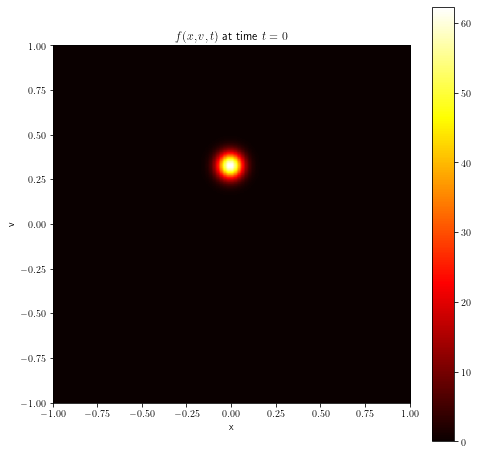

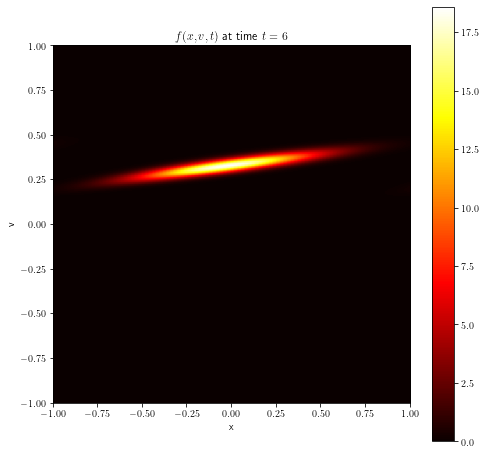

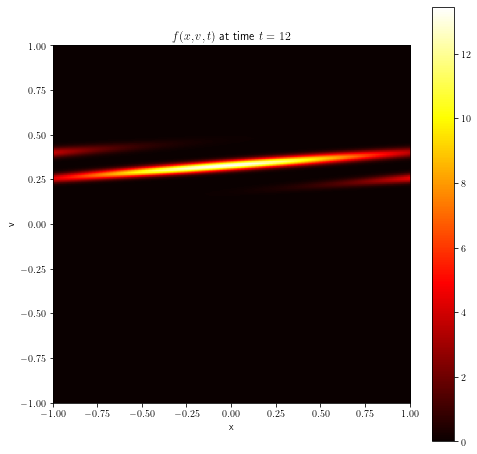

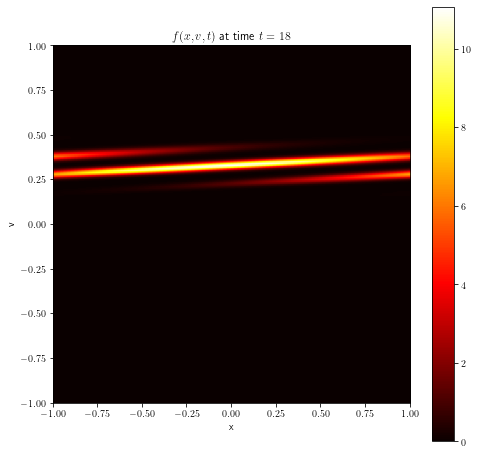

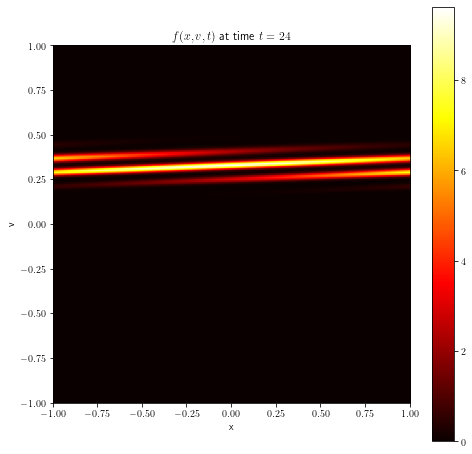

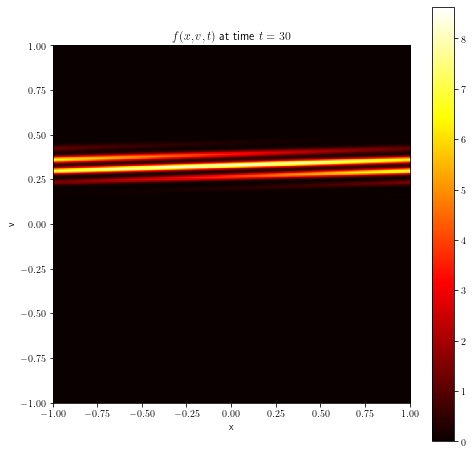

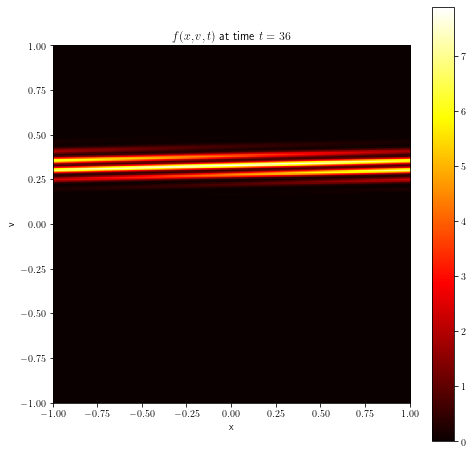

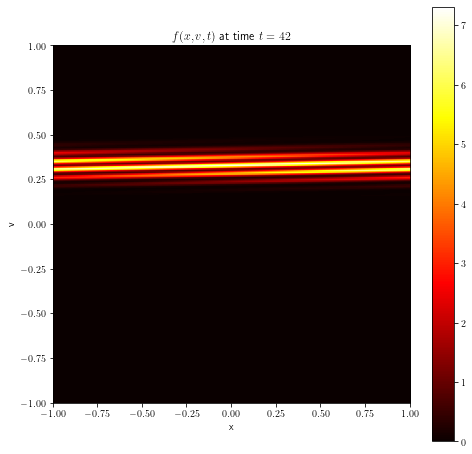

In [9]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()
for i in range(1,8):
    F = first_order_integrate(F,K,U,dx, dx, dv, 6)[3]
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {6*i}$")
    plt.show()

We can also preform a long-time integration, say $t_{f} = 1000$. We plot the $L^1$ and $L^2$ norms of $f$ as a function of time. We expect $L^1$ to be constant and $L^2$ to decay monotonically. We get exactly that! (error analysis)

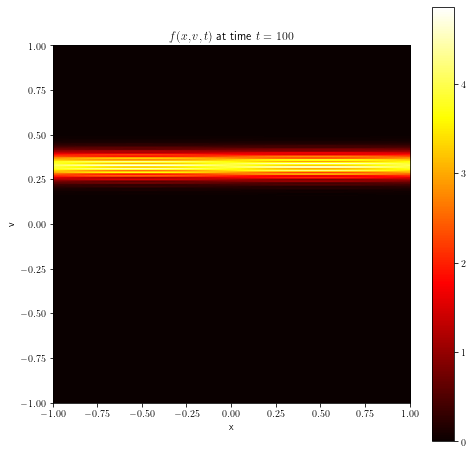

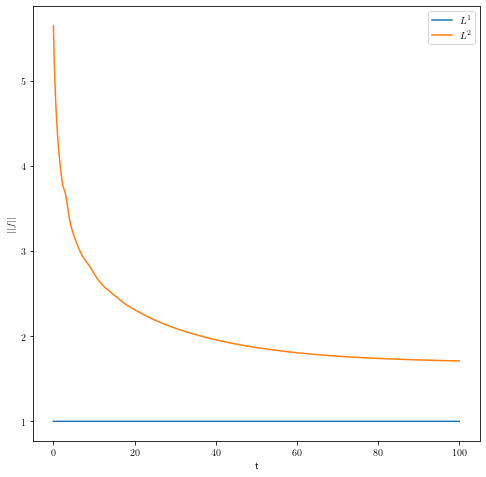

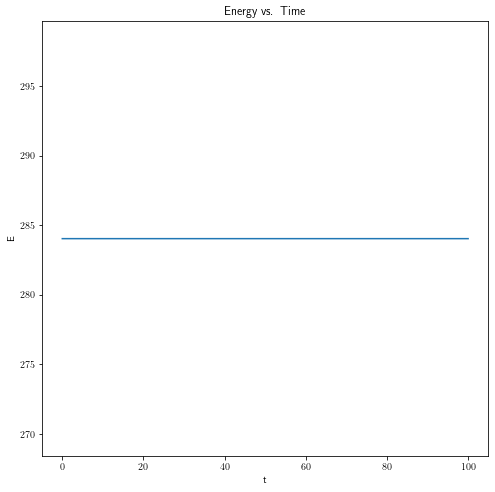

In [4]:
times, L1, L2, F, E = first_order_integrate(Fo(Xdgrid, Vdgrid),K,U,dx, dx, dv, 100)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {100}$")
plt.show()
plt.plot(times,L1, label = "$L^1$")
plt.plot(times,L2, label = "$L^2$")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.legend()
plt.show()
plt.plot(times,E)
plt.xlabel("t")
plt.ylabel("E")
plt.title("Energy vs. Time")
plt.show()

The classical example in Hamiltonian systems is the simple harmonic oscilator with Hamiltonian $H = v^2/2 + x^2/2$. The Hamiltonian flow coresponds to clockwise, circular phase-space orbits with period $2\pi$. The courant condition reads $\Delta t < (1/\Delta x + 1/\Delta v)^{-1}$. Taking $\Delta x = \Delta v$, the largest stable timestep is $\Delta t = \frac{\Delta x}{2}$. Let's setup the problem and plot the solution at timesteps of $2\pi$. 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = v**2/2
U = -x**2/2
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 200
Nv = 200
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*X**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[0,:]
    fo[:,-1] = fo[:,0]
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1, Nx+1) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1,Nv+1) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+1):
    for j in range(Nv+1):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])])

Let's plot the solution at timesteps of $2\pi$. We overlay level sets of $H$. 

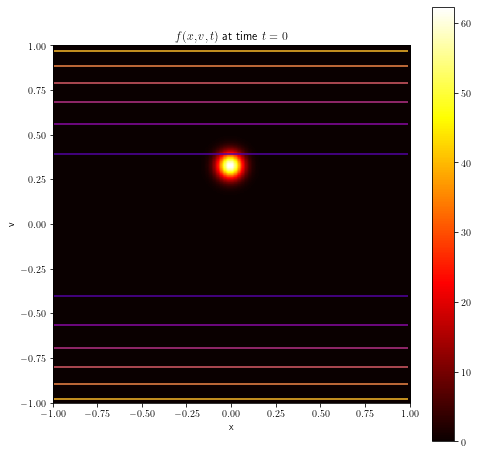

TypeError: first_order_integrate() argument after * must be an iterable, not float

In [10]:
F = Fo(Xdgrid, Vdgrid)
plt.contour(H.transpose(), 6, origin = "lower",extent = (-1,1,-1,1), cmap = "plasma")
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()
for i in range(1,4):
    F = first_order_integrate(F,K,U,dx/2, dx, dv, 2*np.pi)[3]
    plt.contour(H.transpose(), 6, origin = "lower",extent = (-1,1,-1,1), cmap = "plasma")
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {2*i}\pi$")
    plt.show()

Clearly, our first order upwinding method is very diffusive. Let's try a long simulation, say to time $50 \pi$.

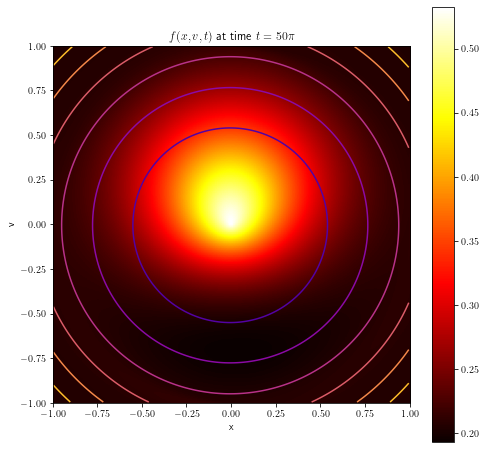

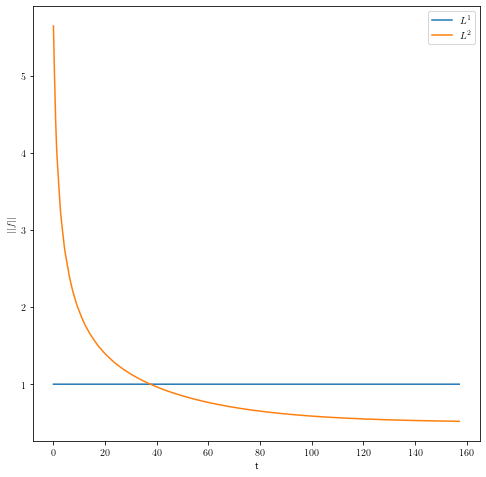

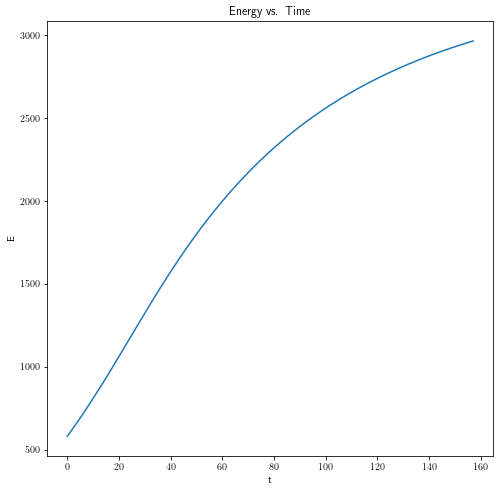

In [7]:
times, L1, L2, F, E = first_order_integrate(Fo(Xdgrid, Vdgrid),K,U,dx/2, dx, dv, 50*np.pi)
plt.contour(H.transpose(), 6, origin = "lower",extent = (-1,1,-1,1), cmap = "plasma")
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {50}\pi$")
plt.show()
plt.plot(times,L1, label = "$L^1$")
plt.plot(times,L2, label = "$L^2$")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.legend()
plt.show()
plt.plot(times,E)
plt.xlabel("t")
plt.ylabel("E")
plt.title("Energy vs. Time")
plt.show()

As expected, the $L^1$ norm is preserved while the $L^2$ norm is decayed monotonically. We see that the diffusion causes the total energy of particle distribution to increase. 

So far, we have not used periodic Hamiltonians. It seems our program is robust enough to deal with such issues. Let's try to use a periodic Hamiltonian, say $H = \sin(\pi v)^2/2\pi + \sin(\pi x)^2/2\pi$. The courant condition for $\Delta x = \Delta v$ is that $\Delta t< \frac{\Delta x}{2}$. 

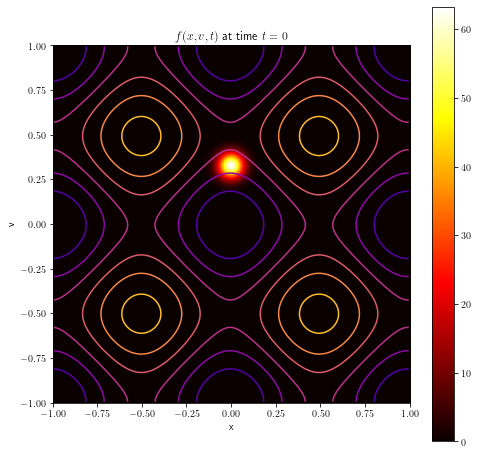

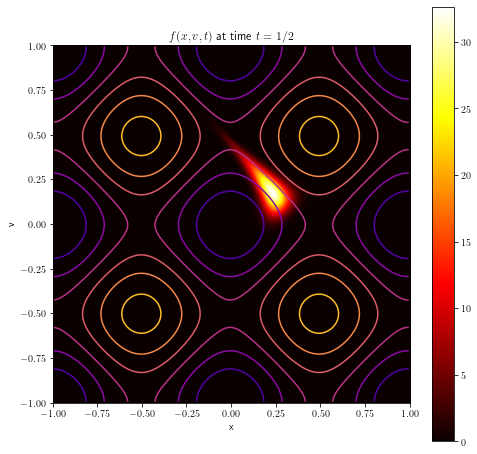

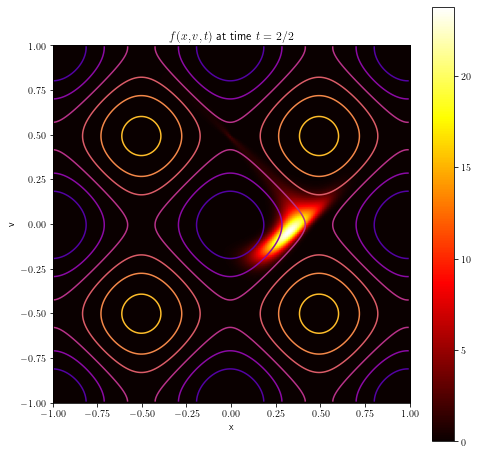

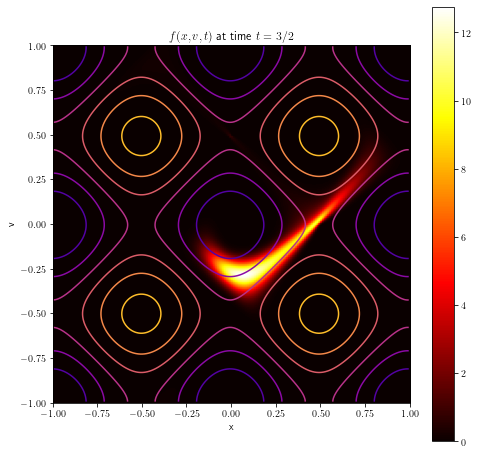

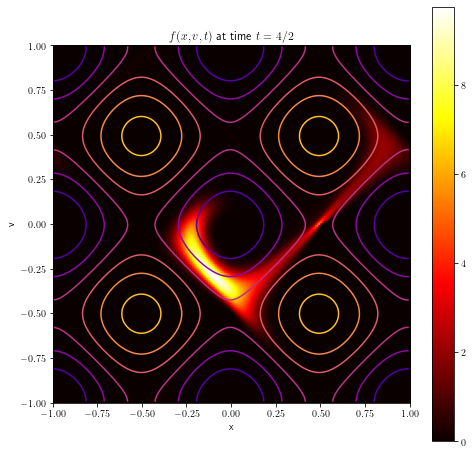

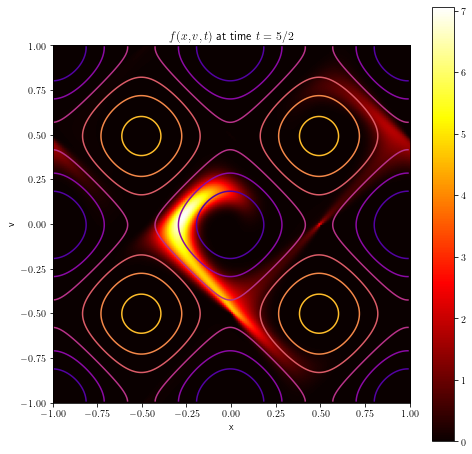

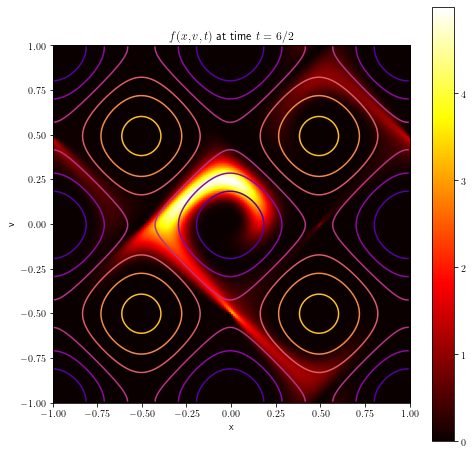

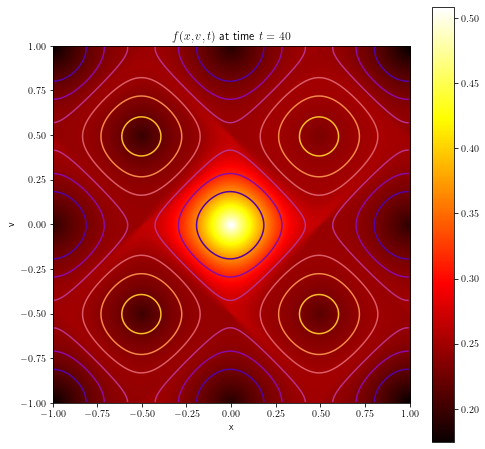

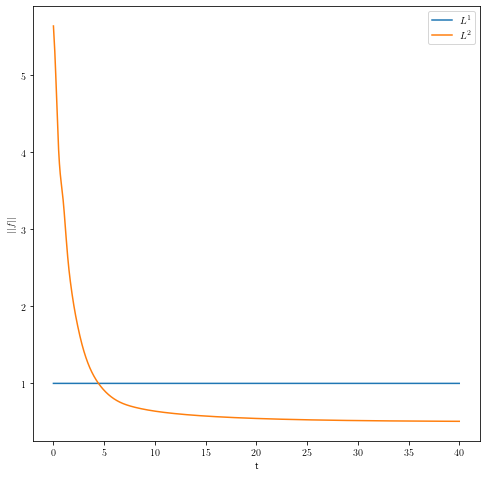

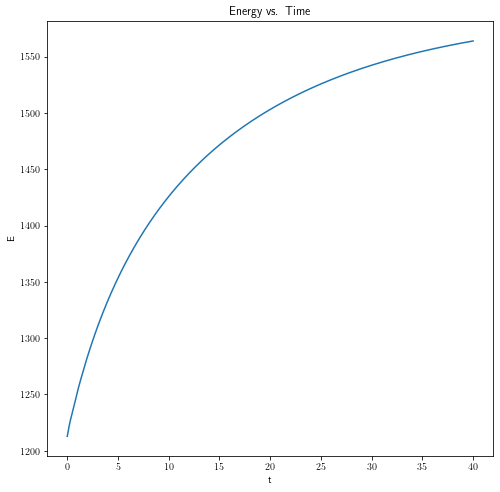

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = sp.sin(v*sp.pi)**2/(2*sp.pi)
U = -sp.sin(x*sp.pi)**2/(2*sp.pi)
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 200
Nv = 200
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*X**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[0,:]
    fo[:,-1] = fo[:,0]
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1, Nx+1) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1,Nv+1) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+1):
    for j in range(Nv+1):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])])

F = Fo(Xdgrid, Vdgrid)
plt.contour(H.transpose(), 6, origin = "lower",extent = (-1,1,-1,1), cmap = "plasma")
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()
for i in range(1,7):
    F = first_order_integrate(F,K,U,dx/2, dx, dv, 1/2)[3]
    plt.contour(H.transpose(), 6, origin = "lower",extent = (-1,1,-1,1), cmap = "plasma")
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {i}/2$")
    plt.show()

times, L1, L2, F, E = first_order_integrate(Fo(Xdgrid, Vdgrid),K,U,dx/2, dx, dv, 40)
plt.contour(H.transpose(), 6, origin = "lower",extent = (-1,1,-1,1), cmap = "plasma")
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap ="hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {40}$")
plt.show()
plt.plot(times,L1, label = "$L^1$")
plt.plot(times,L2, label = "$L^2$")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.legend()
plt.show()
plt.plot(times,E)
plt.xlabel("t")
plt.ylabel("E")
plt.title("Energy vs. Time")
plt.show()


We now move beyond the confines of a constant $H$, and onto the true Vlasov equation where $K = v^2/2$ and where $ q\frac{\partial}{\partial x} \frac{\partial}{\partial x} U(x) = \frac{\partial E}{\partial x}  = q\epsilon_{0} \int dv f(v)dv + C$. $q$ is the signed charge of the particle species represented by $f$, and $\epsilon_{0}$ is a numerical constant. $C$ is a constant representing a uniform neutralizig background charge such that $q \epsilon_{0} \int dx \int dv f + \int dx C = 0$. Thus, in the Vlasov equation, the Hamiltonian depends nontrivially on $f$ itself.  
$$$$ 
For our purposes, we want to simulate electron dynamics so $q = -e$. In some unit choice, we set $\epsilon_{0} e = 1$. 
$$$$
Exactly, we know that 
$$$$
$$
\frac{1}{\Delta x} \int_{x_{i}}^{x_{i+1}} \int dv f = \frac{1}{\Delta x} \sum_{j} \int_{x_{i}}^{x_{i+1}} \int_{v_{j}}^{v_{j+1}} dv f = \sum_{j} f_{i+1/2,j+1/2}\Delta v 
$$
We thus exactly have that 
$$
E(x_{i+1}) - E(x_{i}) = C \Delta x - \Delta v \Delta x \sum_{j} f_{ij}
$$
which is a linear system for $E$. We have the solvability requirement that $C = \frac{1}{2}\Delta x \Delta v\sum_{ij} f_{ij}$. This means there is an infinite number of solutions to the linear systems. We demand that $\sum_{i}E(x_{i}) = 0$ i.e. that $E$ has zero mean. We solve this system by assuming that $E(-1) = 0$ and then solving the system directly. We then subtract the mean of this solution to get $E$. No matrix methods needed. 
$$$$
We can exactly calculate $E(x_{i})$. But what we need is $E(x_{i+1/2})$. The simple solution is to interpolate $E(x_{i+1/2}) = \frac{1}{2}(E_{i} + E_{i+1})$. Another method is to use Fourier interpolation. We start with the simple interpolation function first.

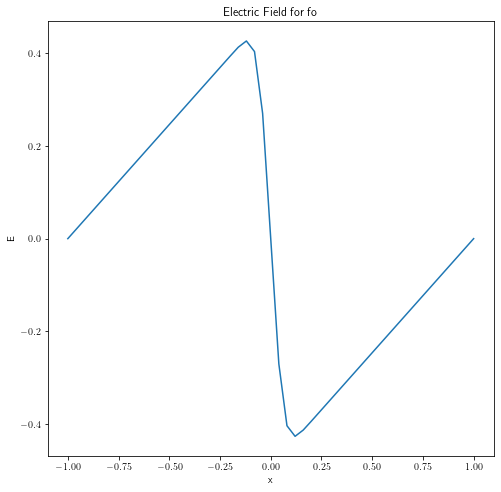

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import math

def get_E(F,dx,dv):
    """
    returns E(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-1],axis = 1)
    C = dx*np.sum(n[0:-1])/2
    E = np.zeros_like(n)
    l = len(n)-1
    for i in range(l-1):
        E[i+1] = E[i] + dx*(C-n[i])
    mean = np.sum(E[0:-1])/l
    return E - mean

def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(Nx)
    V = np.linspace(-1,1,Nv+1)+1/(Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = np.exp(- 200*(V)**2 - 200*X**2)/0.015707963267949588
    Fo += np.ones_like(X)
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

F = Fo(50,20)
E = get_E(F, 2/50, 2/20)
x = np.linspace(-1,1,51)
plt.plot(x,E)
plt.xlabel("x")
plt.ylabel("E")
plt.title("Electric Field for fo")
plt.show()

We now modify our fixed $H$ solver to solve the Vlasov equation. We first use the simple interpolation function.

In [98]:
def E_interp_1(E, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    using kernel $x_{i},x_{i+1}$
    """
    Einterp = np.zeros_like(E)
    Einterp[0:-1] = (E[0:-1] + E[1:])/2
    Einterp[-1] = Einterp[0]
    V = np.empty(Nv+1)
    Egrid = np.meshgrid(E,V)[0]
    return Egrid.transpose()

def get_Vlasov_fluxes_1(F,E, K, Nx, Nv):
    """
    inputs F,K, dx, dv, Ein (an perscribed electric field)
    returns fluxes Fx, Fv 
    """ 
    dx = 2/Nx
    dv = 2/Nv
    U = -E_interp_1(E, Nv)
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv

def frd_euler_1(F, Fx, Fv, dt, dx, dv):
    """
    outputs f^{n+1}, a forward euler step for the Vlasov R
    """
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[0,0:-1]
    F[0:-1,-1] = F[0:-1,0]
    F[-1,-1] = F[0,0]
    return F

def get_K(Nx, Nv):
    """
    return K array
    """
    #define grid
    X = np.linspace(-1,1, Nx+1)
    Vd = np.linspace(-1,1,Nv+1)+1/(Nv) 
    K = np.meshgrid(X,Vd)[1].transpose()
    #K[-1,:] = K[0,:]
    #K[:,-1] = K[:,0]
    return K

def Euler_Integrate_Vlasov_1(F, Nx, Nv, tfin,  c= 1):
    """
    integrates the vlasov equation using 1st order upwinding
    timestep $dt$ is chosen to be $c$ times the largest satifsying the Courant Condition
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$, and E(t_{f})
    """
    dx = 2/Nx
    dv = 2/Nv
    K = get_K(Nx,Nv)
    time = 0
    times = [0]
    L1_norms = [np.sum(F[0:-1,0:-1])*(dx*dv)]
    L2_norms = [np.linalg.norm(F[0:-1,0:-1])*math.sqrt(dx*dv)]
    while time < tfin:
        E = get_E(F,dx, dv)
        plt.show()
        a = np.max(abs(E))
        dt = c/(1/dx + a/dv)
        Fx, Fv = get_Vlasov_fluxes_1(F,E,K,Nx,Nv)
        F = frd_euler_1(F, Fx, Fv, dt, dx, dv)
        L1_norms.append(np.sum(F[0:-1,0:-1])*(dx*dv))
        L2_norms.append(np.linalg.norm(F)*math.sqrt(dx*dv))
        time = time + dt
        times.append(time)
    return times, L1_norms, L2_norms, F, E

def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(Nx)
    V = np.linspace(-1,1,Nv+1)+1/(Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = 10*(10+np.sin(2*np.pi*X)) *(np.exp(- 1000*(V-.3)**2)+np.exp(- 1000*(V+.3)**2))
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo


The first effect we demonstrate is the two-stream instability. In the setup, we assume that $f$ is approximately of the form $f = \delta(v-v_{0}) + \delta(v - v_{0}) + \tilde{f}$ where $\tilde{f}$ is an small perturbation and $v_{0} > 0$ is some flow velocity. We take $\delta(v-v_{0}) \approx G(v-x_{0})$ to be a narrow Gaussian and we take the perturbation to be such that $f = (10+ n(x))(G(v-v_{0}) + G(v-v_{0}))$ with $n(x)$ a sine wave of wavelength $k$. For a fixed $v_{0}$, here taken to be $.3$, one can show that for suitably small $k$, the perturbation will grow exponentially fast in the linear regime. For large $k$, the system is stable with the perturbation only oscilating. Due to numerical diffusion, a high $k$ perturbation simply dies out. 

The most drastic instability occurs when $k$ is small, so let's try $k = 2\pi$. 

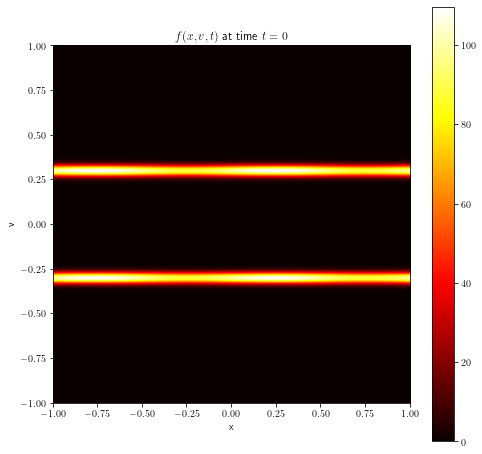

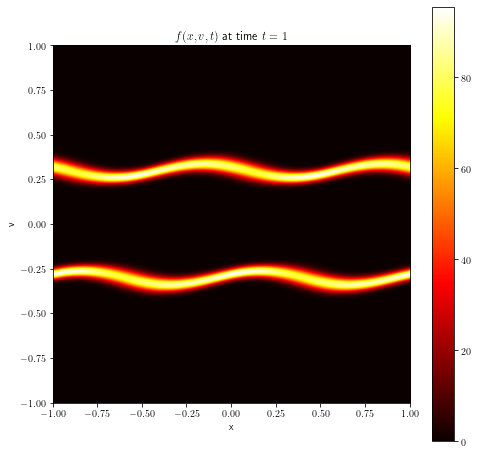

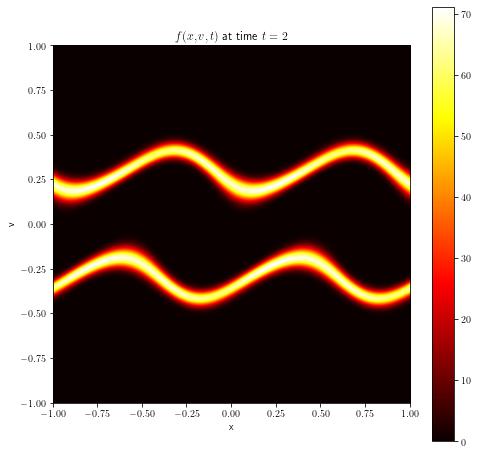

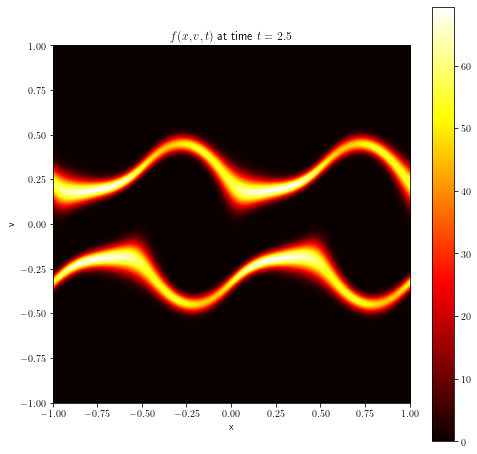

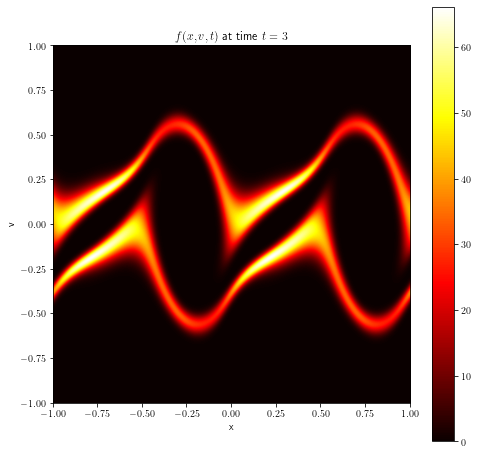

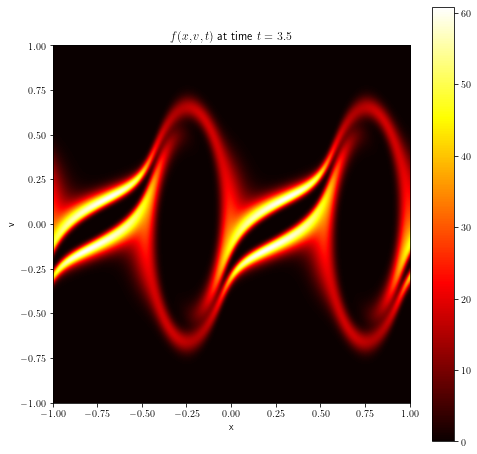

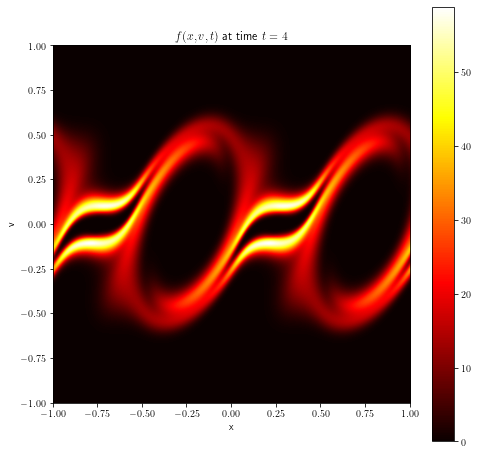

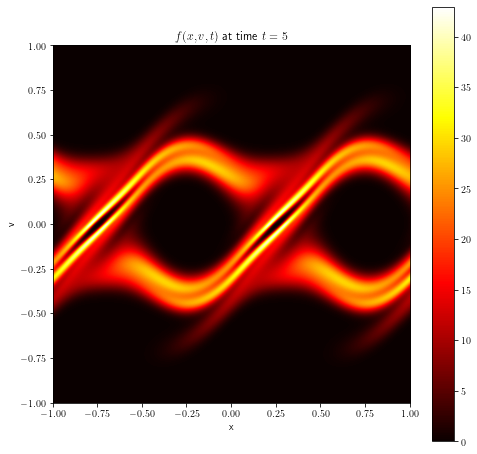

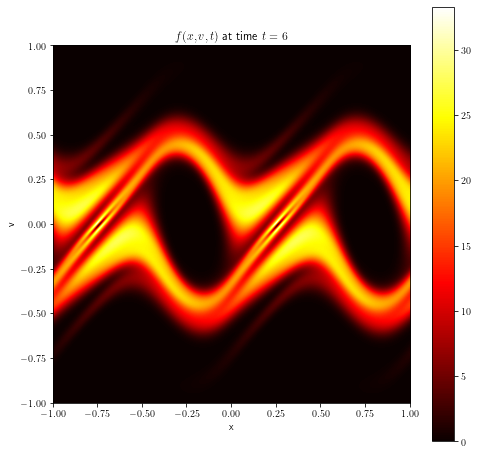

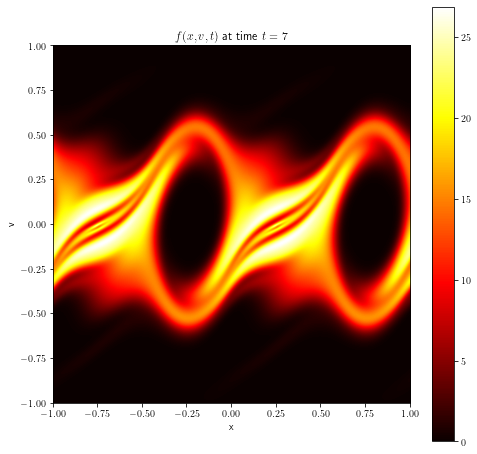

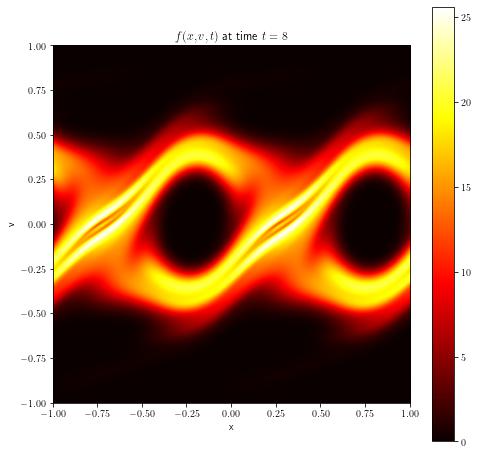

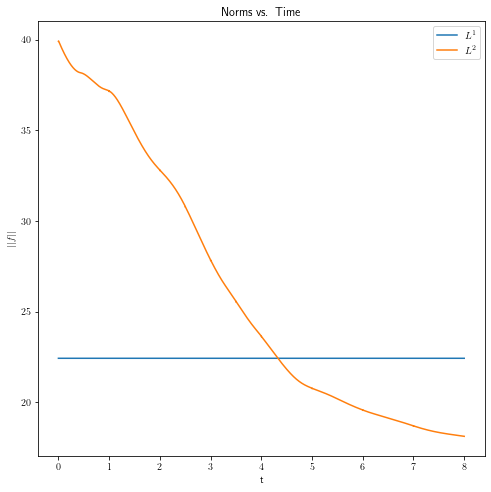

In [71]:
Nx = 600
Ny = 600
Times = [0,1,2,2.5,3, 3.5,4,5,6,7,8]
x = np.linspace(-1,1,Nx+1) + 1/Nx
F = Fo(Nx,Ny)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

times = []
L1tot = []
L2tot = []
for i in range(1,len(Times)):
    time, L1, L2, F, E = Euler_Integrate_Vlasov_1(F,Nx, Ny, Times[i]-Times[i-1])
    times += [t + Times[i-1] for t in time]
    L1tot += L1
    L2tot += L2
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$")
    plt.show()

plt.plot(times, L1tot, label = "$L^1$")
plt.plot(times, L2tot, label = "$L^2$")
plt.legend()
plt.title("Norms vs. Time")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.show()

Great! We have shown the the fluid instability is captured by our simulation.

We can also try higher $k$ modes to see that the system is stable. Let's try $k = 8 \pi$ with the same resolution and amplitude of the perturbation as the last simulation.

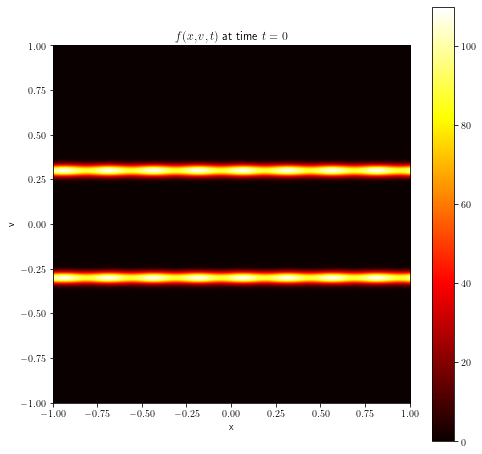

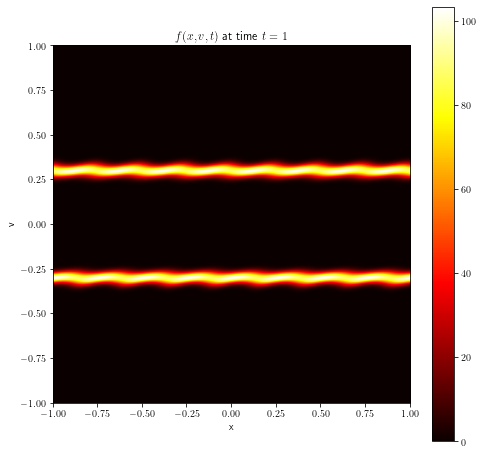

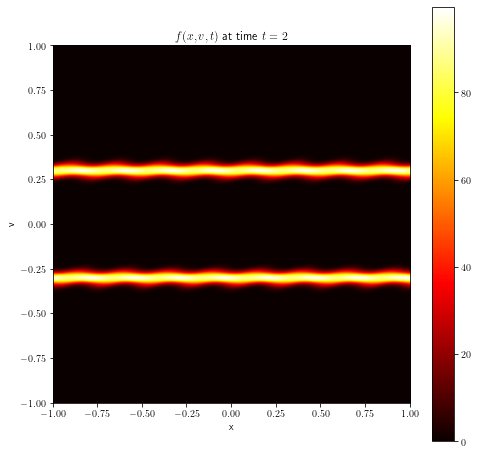

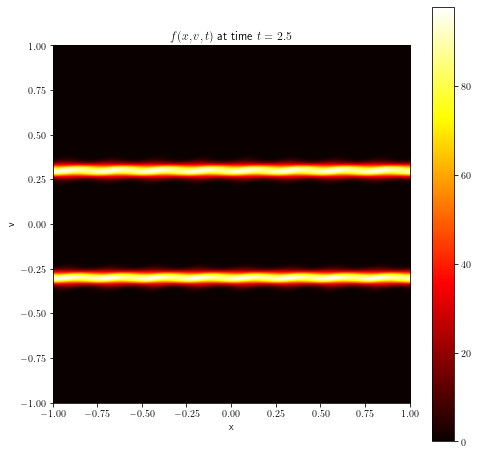

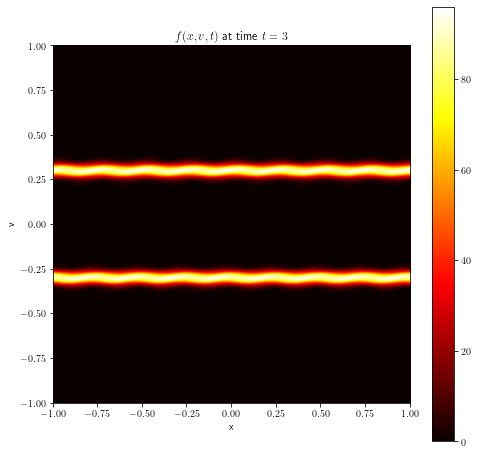

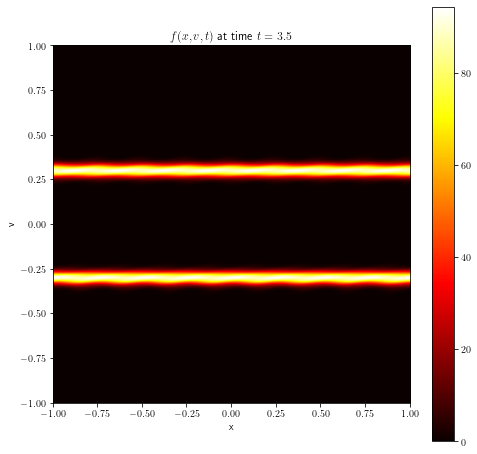

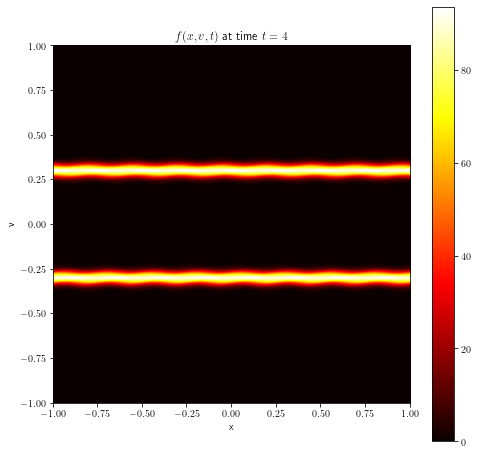

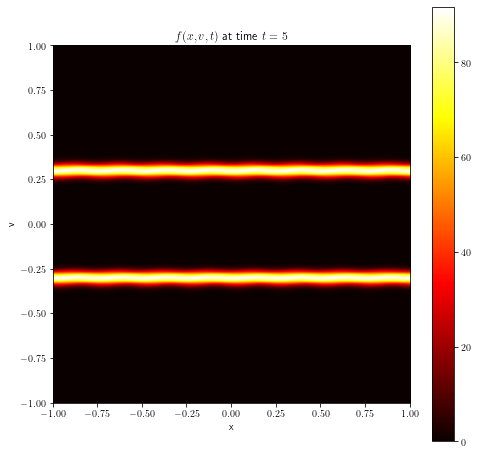

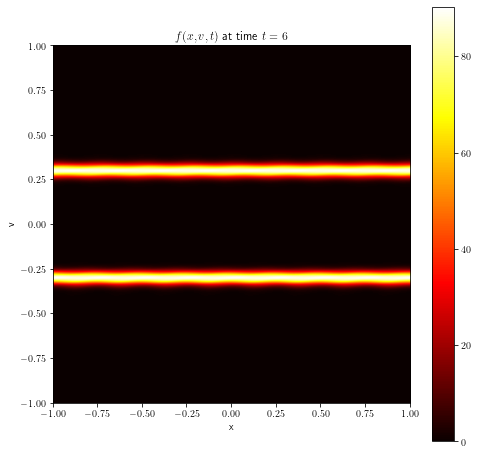

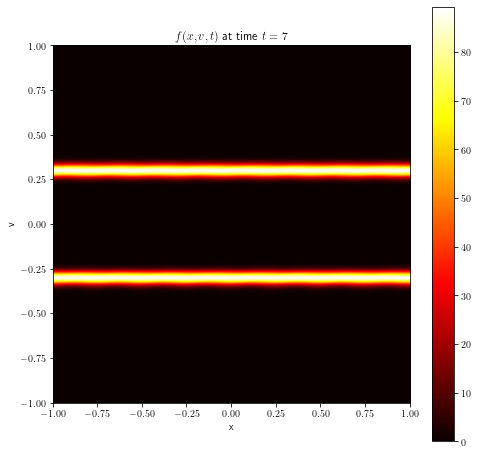

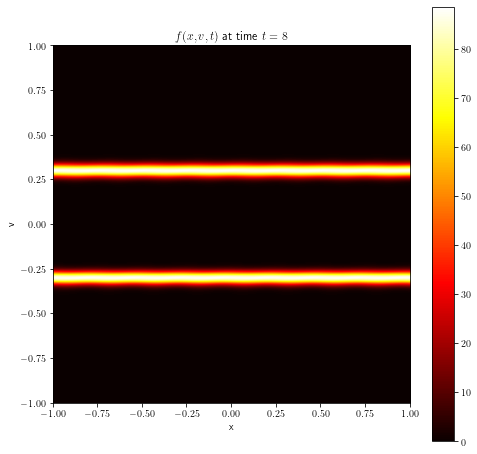

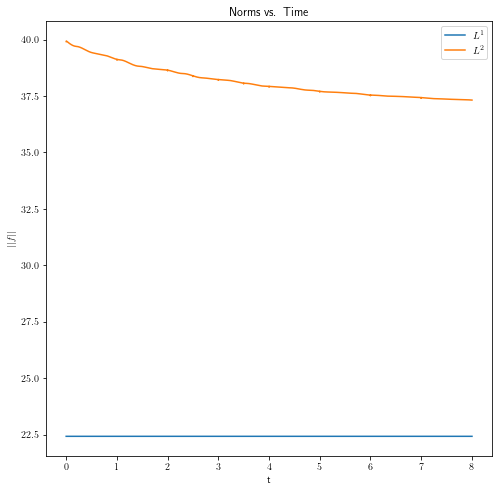

In [13]:
def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(2*Nx)
    V = np.linspace(-1,1,Nv+1)+1/(2*Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = 10*(10+np.sin(8*np.pi*X)) *(np.exp(- 1000*(V-.3)**2)+np.exp(- 1000*(V+.3)**2))
    #Fo += np.exp(- 500*(V)**2)*np.sin(2*np.pi*X)**2
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

Nx = 600
Ny = 600
Times = [0,1,2,2.5,3, 3.5,4,5,6,7,8]
x = np.linspace(-1,1,Nx+1) + 1/Nx
F = Fo(Nx,Ny)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()

times = []
L1tot = []
L2tot = []
for i in range(1,len(Times)):
    time, L1, L2, F, E = Euler_Integrate_Vlasov_1(F,Nx, Ny, Times[i]-Times[i-1])
    times += [t + Times[i-1] for t in time]
    L1tot += L1
    L2tot += L2
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {Times[i]}$")
    plt.show()

plt.plot(times, L1tot, label = "$L^1$")
plt.plot(times, L2tot, label = "$L^2$")
plt.legend()
plt.title("Norms vs. Time")
plt.xlabel("t")
plt.ylabel("$||f||$")
plt.show()

We see that the perturbation in the density does not grow! In fact, because of the numerical diffusion, the amplitude of the perturbation decays with time. This test confirms that our simulation captures the physics correctly. The next effect we demonstrate is perhaps the most important effect in plasma physics. It also defines a natural timescale for most realistic problems. 

In order to properly understand plasma oscilations, we take the first 2 velocity moments of the Vlasov equation. We define $n = \int dv f$, $un = \int dv v f$, $p = \int dv (u-v)^2 f$. Then the Vlasov equation implies that 
$$$$
$$
\partial_{t}n + \partial_{x}(n u) = 0 
$$
$$$$
$$
n (\partial_{t} u + u \partial_{x} u) = -\partial_{x} p - E n
$$
$$$$
$$
\partial_{x}E  = -n + C 
$$
$$$$
Plasma waves arrise by assuming $f = f_{0}(v) + f_{1}(x,v,t)$ where $f_{1}$ is a perturbation. We also assume $ \partial_{x} p$ is negligable. Then $n = n_{0} + n_{1}$, $u = u_{1}$. Ignoring quadratic terms in the small quantities, we get that 
$$$$
$$
\partial_{t} n_{1} = - n_{0} \partial_{x} u_{1} 
$$
$$$$
$$
-\partial_{x}E = n_{1}
$$
$$$$
$$
\partial_{t} u_{1} = - E 
$$
Taking a time derivative of the first equation, we get that 
$$$$
$$
\partial_{t}^2 n_{1} = -n_{0} n_{1} 
$$
which implies that $n_{1}$ oscilates at angular frequency $\omega^2 = n_{0}$. 

To simulate plasma oscilations, we assume the following initial conditions:
$$$$
$f_{0}$ is a Maxwellian with $n_{0} = 1$ i.e. 
$$
f_{0} = e^{-v^2/v_{th}^2} \frac{1}{v_{th} \sqrt{\pi}}
$$
where we take $v_{th} \sim 1/100$. This gives $\omega = 1$.
$$$$
We assume that $f_{1} = 10^{-7} * e^{-v^2/v_{th}^2} \frac{1}{v_{th}\sqrt{\pi}} * n(x)$ where $n(x)$ is a function of $x$ with $n(x) \sim 1$. We assume $v_{th}' \sim 1/50$ so that the pressue term is small. Here we take $n(x)$ to be a narrow Gaussian.
$$$$
To aid visualization, we plot the (negative) charge density $c(x) = n(x) + const.$. We expect to see oscilations in $c(x)$ at the plasma frequency. 

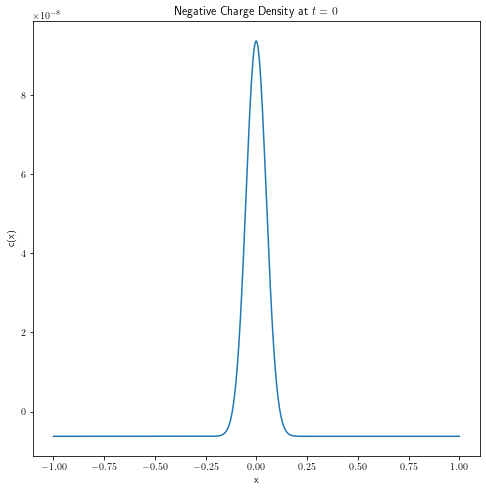

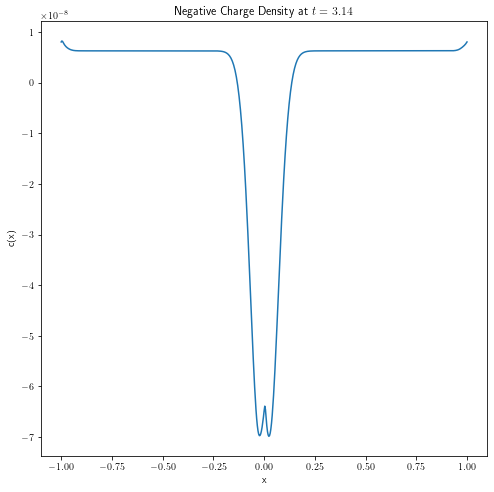

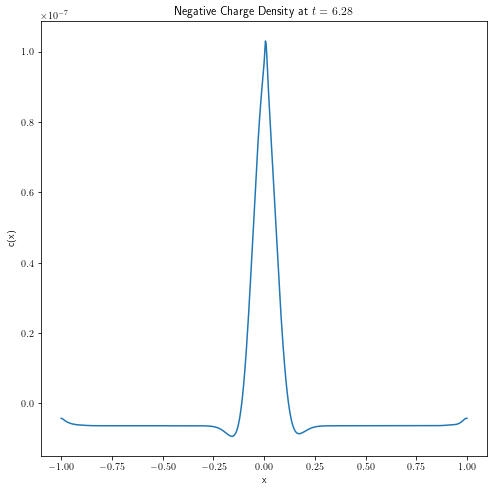

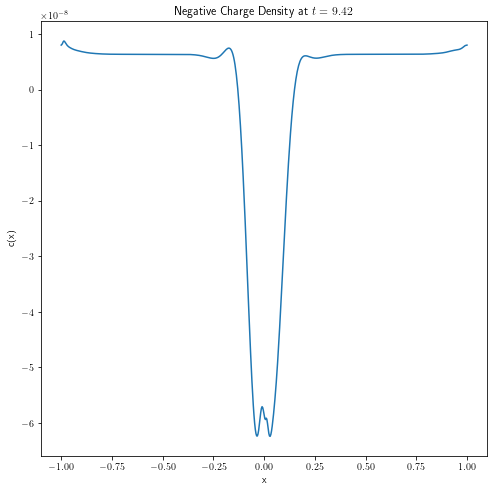

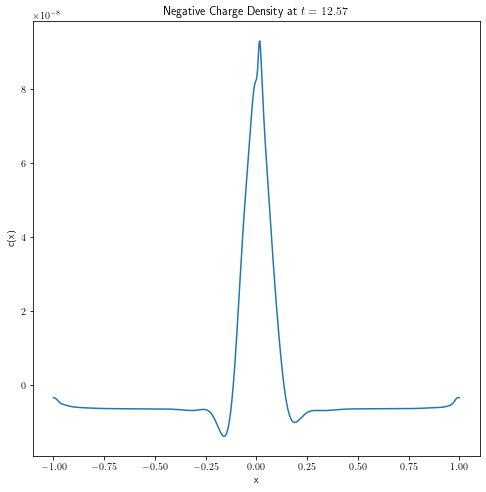

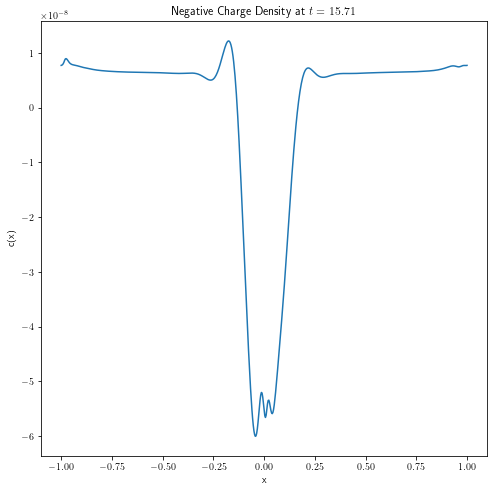

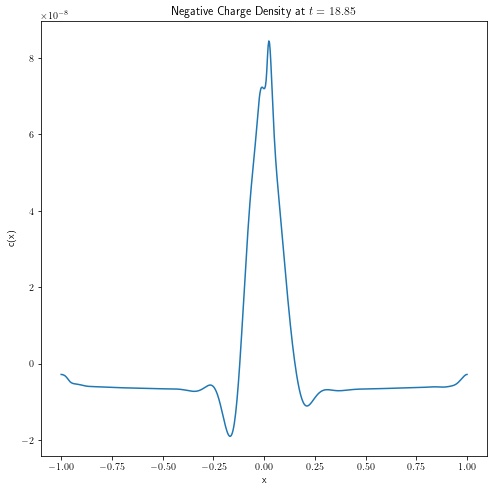

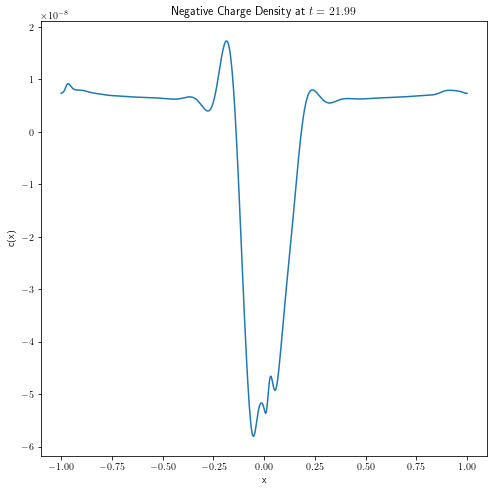

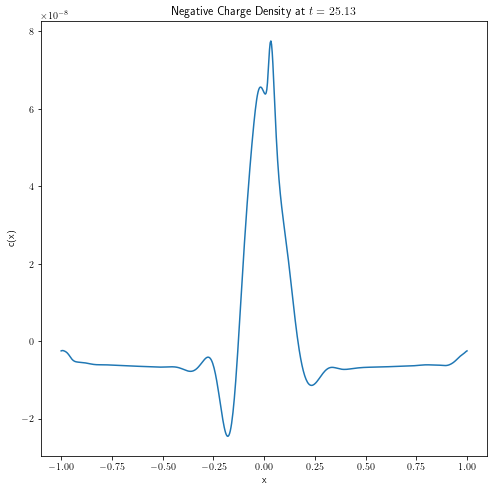

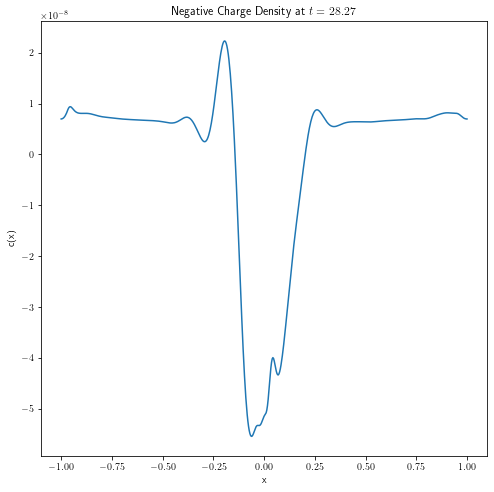

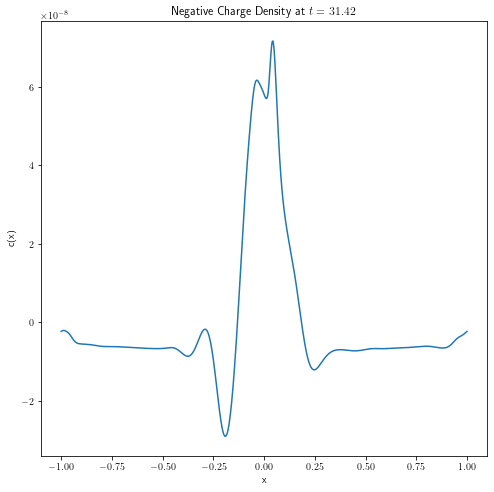

In [14]:
def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(2*Nx)
    V = np.linspace(-1,1,Nv+1)+1/(2*Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = np.exp(- 10000*V**2)/(1/100 * math.sqrt(np.pi)) # f_{0}
    Fo = Fo + 10**(-7) * np.exp(- 10000*V**2)/(1/100 * math.sqrt(np.pi))*\
    (np.exp(-200*X**2))
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

def get_charge(F, dx, dv):
    """
    returns C(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-1],axis = 1)
    C = dx*np.sum(n[0:-1])/2
    return n - C

Nx = 600
Nv = 600
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1,Nx+1) + 1/Nx
F = Fo(Nx,Nv)
Times = [i * np.pi for i in range(11)]
x = np.linspace(-1,1,Nx+1) + 1/Nx
c = get_charge(F,dx,dv)
plt.plot(X,c)
plt.title("Negative Charge Density at $t = 0$")
plt.xlabel("x")
plt.ylabel("c(x)")

for i in range(1,len(Times)):
    F= Euler_Integrate_Vlasov_1(F,Nx, Nv, Times[i]-Times[i-1])[3]
    c = get_charge(F,dx,dv)
    plt.plot(X,c)
    plt.title(f"Negative Charge Density at $t = {Times[i]:.2f}$")
    plt.xlabel("x")
    plt.ylabel("c(x)")
    plt.show()

We get oscilations at the desired frequency! Of course, a mix of nonlinear effects and an inperfect solver means the profile of $c(x)$ distorts with time. Nonetheless, this shows that the physics of our solver is correct! 

We have now completed a fully functional Vlasov solver. Yet our solver leaves much to be desired in term of accuracy. In the next section, we improve on the electric field interpolator using Fourier interpolation. In the Vlasov equation, the electric field is very much a global quantity, and assumed to be smooth. It therefore makes sense to use as much information about the electric field to get a good interpolations. The only problem is that Runge phenoma occurs near sharp charge gradients. This could be problematic. 

Let's suppose we know $E(x_{i})$ exactly at the $N$ equally-spaced points $x_{i}$. Then we can write 
$$$$
$$
E(x_{n}) = \frac{1}{N} \sum_{k=0}^{N-1} \exp(2\pi i \frac{k n}{N}) E(k) 
$$
$$$$
where
$$
E(k) = \sum_{n=0}^{N-1} \exp(-2 \pi i \frac{k n}{N}) E(x_{n})
$$
For the moment, it is easiest to think of $E(x_{i})$ as the point values of an electric field $E(x)$ on $[0,1]$. Then $x_{n}/h = x_{n}N = n$. If $N-1$ is odd, then let $N-1//2$ be the floor of $N-1$. We then have that
$$$$

$$
E(x_{n}) = \frac{1}{N} \sum_{k=0}^{(N-1)//2} \exp(2\pi i  k x_{n}) E(k) + \frac{1}{N} \sum_{k=(N-1)//2+1}^{N-1} \exp(2\pi ik x_{n} ) E(k) 
$$
$$$$
$$
= E(k=0)/N + \frac{1}{N} \sum_{k=1}^{(N-1)//2} \exp(2\pi i  k x_{n}) E(k) + \frac{1}{N} \sum_{k=1}^{(N-1)//2+1} \exp(-2\pi i k x_{n} ) E(k)^* 
$$
where we used that $E$ is real. It therefore makes sense to interpolate 
$$$$
$$
E(x) = E(k=0)/N + \frac{1}{N} \sum_{k=1}^{(N-1)//2} \exp(2\pi i  k x) E(k) + \frac{1}{N} \sum_{k=1}^{(N-1)//2+1} \exp(-2\pi i k x) E(k)^* 
$$
implying that 
$$$$
$$
E(x_{n}) = E(k=0)/N + \frac{1}{N} \sum_{k=1}^{(N-1)//2} \exp(2\pi i  k x_{n}) E(k)e^{ih\pi k} + \frac{1}{N} \sum_{k=1}^{(N-1)//2+1} \exp(-2\pi i k (x+h/2)) E(k)^* e^{-ih\pi k} 
$$
where $h = \Delta x/2$. We pick $N$ to be a power of $2$ to make the FFT as quick as possible.

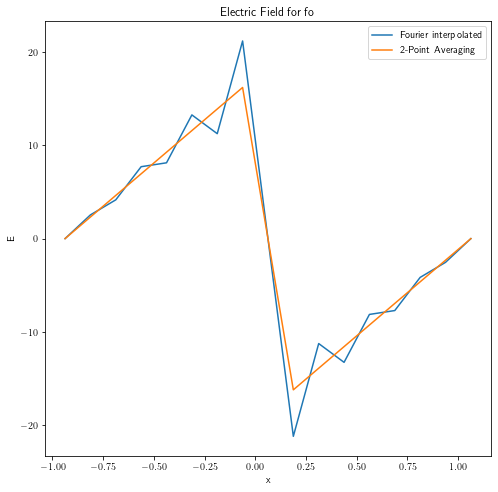

In [95]:
from scipy.fft import fft, ifft, fftfreq

def E_interp_simple(E, Nx, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    using kernel $x_{i},x_{i+1}
    """
    Eint = np.empty(Nx+1)
    Eint[0:-1] = (E[1:] + E[0:-1])/2
    Eint[-1] = Eint[0]
    return Eint

def E_interp_fourier(E, Nx, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    using kernel $x_{i},x_{i+1}
    """
    i = complex(0,1)
    Eint = np.empty(Nx+1)
    exp_freq = np.exp(i*np.pi*fftfreq(Nx))
    Ek = fft(E[0:-1])
    Eint[0:-1] = np.real(ifft(fft(E[0:-1])*exp_freq))
    Eint[-1]=Eint[0]
    return Eint

def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(2*Nx)
    V = np.linspace(-1,1,Nv+1)+1/(2*Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = 100*np.exp(- 200*(V)**2 - 1000*X**2)/0.015707963267949588
    Fo += np.ones_like(X)
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

Nx = 2**4
Nv = 10
F = Fo(Nx,Nv)
E = get_E(F, 2/Nx, 2/Nv)
Einterp2 = E_interp_fourier(E, Nx, Nv)
Einterp1 = E_interp_simple(E,Nx,Nv)
x = np.linspace(-1,1,Nx+1) + 1/Nx
plt.plot(x,Einterp2, label = "Fourier interpolated")
plt.plot(x,Einterp1, label = "2-Point Averaging")
plt.xlabel("x")
plt.ylabel("E")
plt.title("Electric Field for fo")
plt.legend()
plt.show()


Let's try the solver with Fourier interpolation

In [ ]:

def E_interp_2(E, Nx, Nv):
    """
    interpolates E(x_{i}) to E(x_{i+1/2}) and returns an array
    using kernel $x_{i},x_{i+1}
    """
    i = complex(0,1)
    Eint = np.empty(Nx+1)
    exp_freq = np.exp(i*np.pi*fftfreq(Nx))
    Ek = fft(E[0:-1])
    Eint[0:-1] = np.real(ifft(fft(E[0:-1])*exp_freq))
    Eint[-1]=Eint[0]
    V = np.empty(Nx+1)
    return np.meshgrid(Eint,V)[0].transpose()

def get_Vlasov_fluxes_2(F,E, K, Nx, Nv):
    """
    inputs F,K, dx, dv, Ein (an perscribed electric field)
    returns fluxes Fx, Fv 
    """ 
    dx = 2/Nx
    dv = 2/Nv
    U = -E_interp_2(E, Nx, Nv)
    Fx = np.zeros_like(F)
    Fv = np.zeros_like(F)
    Fx[1:, :] = K[1:,:]*(F[1:,:] + F[0:-1,:])/2 - abs(K[1:,:])*(F[1:,:] -  F[0:-1,:])/2
    Fv[:, 1:] = U[:,1:]*(F[:,1:]+ F[:,0:-1])/2 - abs(U[:,1:])*(F[:,1:]- F[:,0:-1])/2
    Fx[0,:] = Fx[-1,:]
    Fv[:,0] = Fv[:,-1]
    return Fx, Fv

def frd_euler_2(F, Fx, Fv, dt, dx, dv):
    """
    outputs f^{n+1}, a forward euler step for the Vlasov R
    """
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[0,0:-1]
    F[0:-1,-1] = F[0:-1,0]
    F[-1,-1] = F[0,0]
    return F

def get_K(Nx, Nv):
    """
    return K array
    """
    #define grid
    X = np.linspace(-1,1, Nx+1)
    Vd = np.linspace(-1,1,Nv+1)+1/(Nv) 
    K = np.meshgrid(X,Vd)[1].transpose()
    #K[-1,:] = K[0,:]
    #K[:,-1] = K[:,0]
    return K

def Euler_Integrate_Vlasov_2(F, Nx, Nv, tfin,  c= 1):
    """
    integrates the vlasov equation using 1st order upwinding
    timestep $dt$ is chosen to be $c$ times the largest satifsying the Courant Condition
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$, and E(t_{f})
    """
    dx = 2/Nx
    dv = 2/Nv
    K = get_K(Nx,Nv)
    time = 0
    times = [0]
    L1_norms = [np.sum(F[0:-1,0:-1])*(dx*dv)]
    L2_norms = [np.linalg.norm(F[0:-1,0:-1])*math.sqrt(dx*dv)]
    while time < tfin:
        E = get_E(F,dx, dv)
        plt.show()
        a = np.max(abs(E))
        dt = c/(1/dx + a/dv)
        Fx, Fv = get_Vlasov_fluxes_2(F,E,K,Nx,Nv)
        F = frd_euler_2(F, Fx, Fv, dt, dx, dv)
        L1_norms.append(np.sum(F[0:-1,0:-1])*(dx*dv))
        L2_norms.append(np.linalg.norm(F)*math.sqrt(dx*dv))
        time = time + dt
        times.append(time)
    return times, L1_norms, L2_norms, F, E

Let's try to recreate plasma oscilations with our higher-order electric field interpolator. We compare to the simple averaging scheme previously used. 

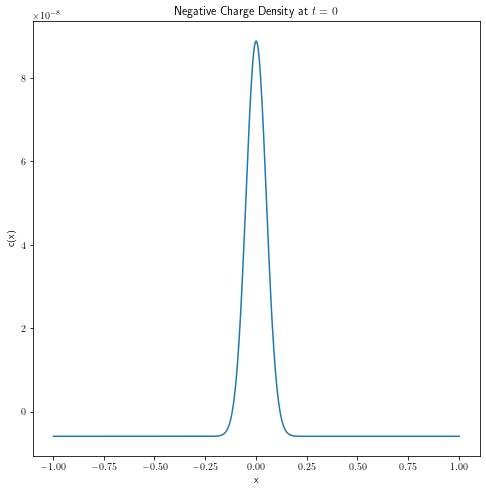

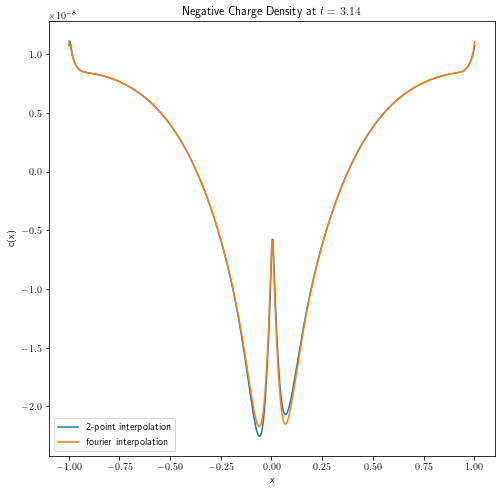

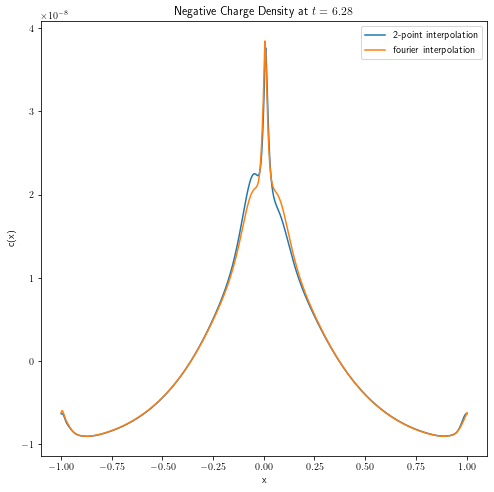

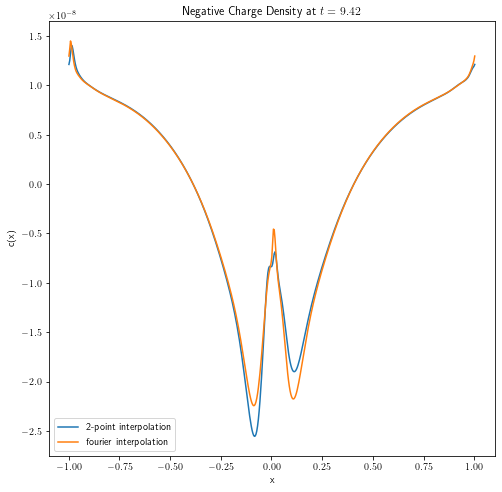

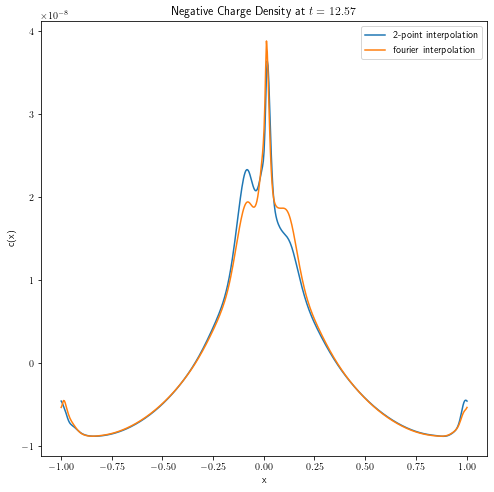

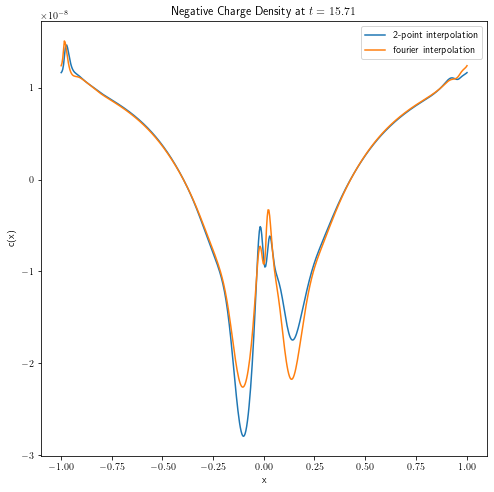

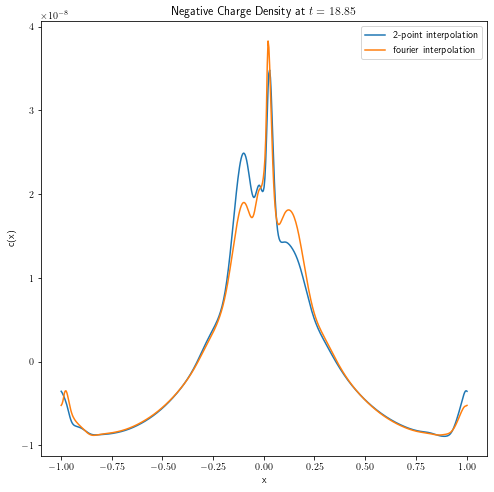

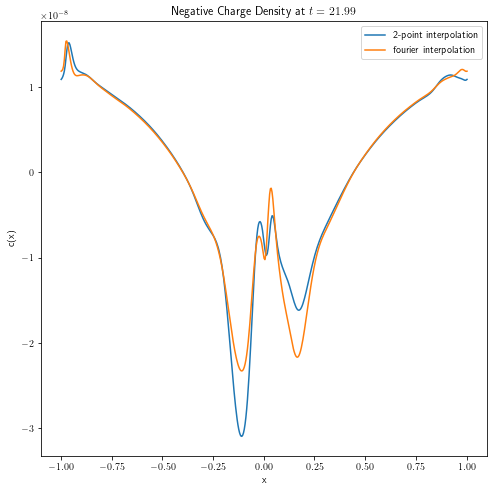

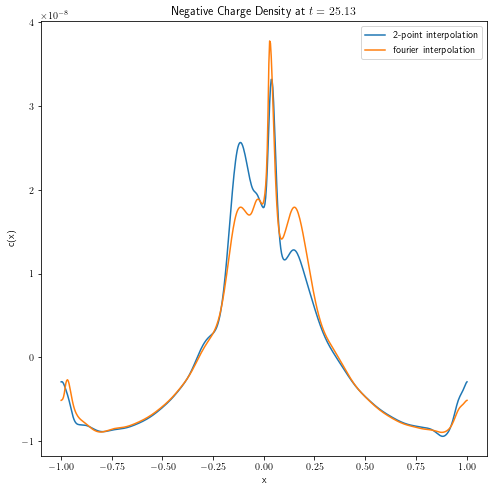

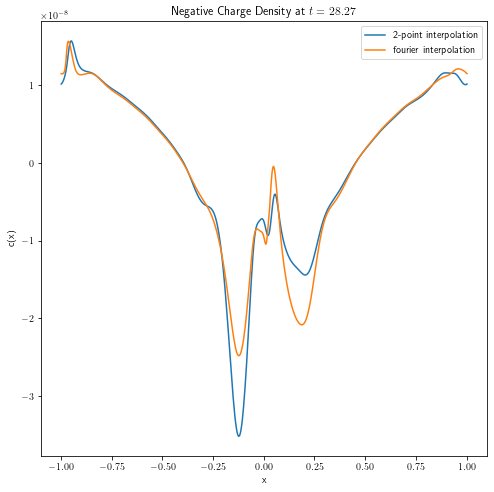

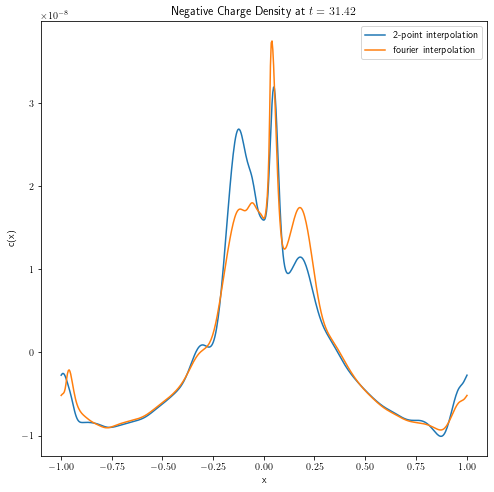

In [132]:
def Fo(Nx,Nv):
    """
    initial conditions of f
    """
    X = np.linspace(-1,1,Nx+1)+1/(2*Nx)
    V = np.linspace(-1,1,Nv+1)+1/(2*Nv)
    X,V = np.meshgrid(X,V)
    X = X.transpose()
    V = V.transpose()
    Fo = np.exp(- 10000*V**2)/(1/100 * math.sqrt(np.pi)) # f_{0}
    Fo = Fo + 10**(-8) *.3* np.exp(- 10*V**2)/(1/100 * math.sqrt(np.pi))*\
    (np.exp(-200*X**2))
    # inposes periodicity
    Fo[-1,:] = Fo[0,:]
    Fo[:,-1] = Fo[:,0]
    return Fo

def get_charge(F, dx, dv):
    """
    returns C(x_{i}) as numpy array
    """
    n = dv*np.sum(F[:,0:-1],axis = 1)
    C = dx*np.sum(n[0:-1])/2
    return n - C

Nx = 512
Nv = 512
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1,Nx+1) +1/Nx
Ffourier = Fo(Nx,Nv)
Fsimple = Fo(Nx,Nv)
Times = [i* np.pi for i in range(11)]
x = np.linspace(-1,1,Nx+1) + 1/Nx
c = get_charge(Fsimple,dx,dv)
plt.plot(X,c)
plt.title("Negative Charge Density at $t = 0$")
plt.xlabel("x")
plt.ylabel("c(x)")

for i in range(1,len(Times)):
    Ffourier= Euler_Integrate_Vlasov_2(Ffourier,Nx, Nv, Times[i]-Times[i-1])[3]
    Fsimple = Euler_Integrate_Vlasov_1(Fsimple,Nx,Nv, Times[i] - Times[i-1])[3]
    cfourier = get_charge(Ffourier,dx,dv)
    csimple = get_charge(Fsimple,dx,dv)
    plt.plot(X,csimple, label = "2-point interpolation")
    plt.plot(X,cfourier, label = "fourier interpolation")
    plt.title(f"Negative Charge Density at $t = {Times[i]:.2f}$")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("c(x)")
    plt.show()

We see that the higher-order electric field interpolator keeps the charge distribution more symmetric. Qualitativly, both the 2-point and the Fourier interpolation schemes predict the same evolution of the distribution function.

We now move onto finding higher-order schemes for the Vlasov equation. Recall, we had to make 2 approximations. First, we had to the find the pointwise value of $f$ at the cell boundaries. Then, we had to integrate $f$ to against $U$ and $K$ to get the numerical fluxes. Let us look for better ways to approximate $f$ on the boundaries. 

Suppose that in each cell, $f$ is locally of a linear form $f = f_{i+1/2,j+12} + a_{ij}(x-x_{i+1/2}) + b_{ij}(v - v_{j+1/2})$. Extending this formula beyond the domain of validity, we should expect that, for example, 
$$$$
$$
f_{i+1/2,j+3/2} = \frac{1}{\Delta x \Delta v} \int_{x_{i}}^{x_{i+1}} \int_{v_{j+1}}^{v_{j+2}} f = f_{i+1/2,j+1/2} +  \Delta v b_{ij}
$$
$$$$
or that $b_{ij} = \frac{1}{\Delta v}(f_{i+1/2,j+3/2} - f_{i+1/2,j+1/2}) = \frac{1}{\Delta v}(f_{i+1/2,j+1/2} - f_{i+1/2,j-1/2}) \approx \frac{1}{\Delta x} \int_{x_{i}}^{x_{i+1}} f(v_{j+1/2}) \approx f(x_{i+1/2},v_{j+1/2})$. We have something similar for $a_{ij}$. The exact choice of $a$ and $b$ will depend on the boundary we are considering and our upwinding. This implies that either 
$$$$
$$
f^{-} (x_{i+1}, v_{j+1/2}) \approx \frac{1}{2}(f_{i+3/2, j+1/2} + f_{i+1/2,j+1/2})
$$
or 
$$
f^{-}(x_{i+1}, v_{j+1/2}) \approx \frac{1}{2}(3 f_{i+1/2, j+1/2} -f_{i-1/2,j+1/2}) 
$$
or 
$$$$
$$
f^{-}(x_{i+1}, v_{j+1/2}) \approx \frac{1}{4}(4f_{i+1/2, j+1/2} + f_{i+3/2,j+1/2}-f_{i-1/2,j+1/2}) 
$$
$$$$
Similar equations for the other pointwise approximations to $f$ hold. Respectivly, these choices corespond to Lax-Wendorff, Beam-Warming, and Fromm-like schemes. We adopt the last, Fromm-like, approach of averaging the two approximations. This amounts to computing the slopes $a$ and $b$ with central-difference. Then we take
$$
f^{+}(x_{i+1}, v_{j+1/2}) \approx \frac{1}{4}(4f_{i+3/2, j+1/2} - f_{i+5/2,j+1/2}+f_{i+1/2,j+1/2}) 
$$
$$$$
At a given interface, the choice of using $f^{-}$ or $f^{+}$ for the flux is determined by upwinding. This amounts to defining 
$$$$
$$
K'(v_{j+1/2}) f(x_{i+1}, v_{j+1/2}) = \frac{1}{8}(4f_{i+1/2, j+1/2} + f_{i+3/2,j+1/2}-f_{i-1/2,j+1/2})(K' + |K'|)(x_{i+1})
$$
$$$$
$$
 + \frac{1}{8}(4f_{i+3/2, j+1/2} - f_{i+5/2,j+1/2}+f_{i+1/2,j+1/2})(K' - |K'|)
$$
$$$$
$$
= \frac{K'}{8}(5f_{i+1/2, j+1/2} + 5f_{i+3/2,j+1/2}-f_{i-1/2,j+1/2} - f_{i+5/2,j+1/2}) + \frac{|K'|}{8}(3f_{i+1/2, j+1/2} -3f_{i+3/2, j+1/2}-f_{i-1/2,j+1/2} + f_{i+5/2,j+1/2})
$$
$$$$
Artifical diffusion is needed in this equation, and will be added later.
$$$$
It is interesting to note it is equally valid to view $f(x_{i+1}, v_{j+1/2})$ as either the pointwise approximation to $f$ or as $\frac{1}{\Delta x} \int_{v_{i}}^{v_{i+1}} dv f(x_{i+1},v)$. Both are consistant with the locally linear approximation of $f$. The pointwise point of view is nonetheless more convient. 
$$$$
Suppose we know $f$ on the boundaries of the cells. Let's call these points $f_{i+1/2, j}$ and $f_{i,j+1/2}$. Then $U(x)f(x,v_{j})$ can be approximated by a degree two polynomial on $[x_{i},x_{i+1}]$ using Legendre interpolation on the 3 point kernel $x_{i-1/2}, x_{i+1/2}, x_{i+3/2}$ using the points $f_{i-1/2, j}, f_{i+1/2,j}, f_{i+3/2,j}$. Using this interpolation, we have that 
$$$$
$$
\bar{F}^{v}_{i+1/2,j} = \frac{1}{\Delta x} \int_{x_{i}}^{x_{i+1}} U'(x)f(x,v_{j}) \approx 
U'(x_{i+1/2})f(x_{i+1/2},v_{j}) + \frac{U'(x_{i+3/2})f(x_{i+3/2},v_{j}) + U'(x_{i-1/2})f(x_{i-1/2},v_{j})-2U'(x_{i+1/2})f(x_{i+1/2},v_{j})}{24} 
$$
$$$$
We similarly have that 
$$$$
$$
\bar{F}^{x}_{i,j+1/2} = \frac{1}{\Delta v} \int_{v_{j}}^{v_{j+1}} K'f(x_{i}, v) dv \approx  K'(v_{j+1/2})f(x_{i},v_{j+1/2}) + \frac{K'(v_{j+3/2})f(x_{i},v_{j+3/2}) + K'(v_{j-1/2})f(x_{i},v_{j-1/2})-2K'(v_{j+1/2})f(x_{i},v_{j+1/2})}{24} 
$$


Now is time to do some stability analysis. The finite-volume Vlasov equation is 
$$ $$$$
\partial_{t} f_{i+1/2,j+1/2}(t) + \frac{\bar{F}^{x}_{i+1,j+1/2} (t) - \bar{F}^{x}_{i,j+1/2}(t)}{\Delta x} + \frac{\bar{F}^{v}_{i+1/2,j+1}(t)- \bar{F}^{v}_{i+1/2,j}(t)}{\Delta v} = 0
$$
$$$$
Let's suppose that $f(x)$ only and that $U(x) = 0$. Then $F^{v} = 0$ implying in this special case that 
$$ $$$$
\partial_{t} f_{i+1/2, j+1/2}(t) + \frac{\bar{F}^{x}_{i+1,j+1/2} (t) - \bar{F}^{x}_{i,j+1/2}(t)}{\Delta x} = 0
$$
In the $j$ region where $K' > 0$ uniformly we have that 
$$$$
$$
\partial_{t}f_{i+1/2, j+1/2} + \frac{a_{j+1/2}}{4 \Delta x}(f_{i+3/2,j+1/2}+ 3f_{i+1/2, j+1/2} -5f_{i-1/2,j+1/2} +f_{i-3/2,j+1/2}) a_{j+1/2} = 0 
$$
$$$$
where $a_{j+1/2} = \frac{K'(v_{j+3/2}) + K'(v_{j-1/2})+22K'(v_{j+1/2})}{24} > 0$. This is nothing by the Fromm scheme without artifical diffusion. Making the timstep discrete, we know we need to add the arficial diffusion term to get the fully discrete Fromm scheme.
$$
$$$$
\frac{f_{i+1/2,j+1/2}^{n+1} -f_{i+1/2,j+1/2}^{n}}{\Delta t} + \frac{a_{j+1/2}}{4 \Delta x}(f_{i+3/2,j+1/2}+ 3f_{i+1/2, j+1/2} -5f_{i-1/2,j+1/2} +f_{i-3/2,j+1/2}) a_{j+1/2} = \frac{a_{j+1/2}^2 \Delta t}{4 \Delta x^2}\left( f_{i+3/2, j+1/2} - f_{i+1/2, j+1/2} -f_{i-1/2, j+1/2} + f_{i-3/2, j+1/2} \right) 
$$
where $\partial_{f} = \frac{f^{n+1} - f^{n}}{\Delta t}$. For $K' < 0$ we have that 
$$$$
$$
\frac{f_{i+1/2,j+1/2}^{n+1} -f_{i+1/2,j+1/2}^{n}}{\Delta t} + \frac{a_{j+1/2}}{4 \Delta x}(f_{i+3/2,j+1/2}+ 3f_{i+1/2, j+1/2} -5f_{i-1/2,j+1/2} +f_{i-3/2,j+1/2}) a_{j+1/2} = \frac{a_{j+1/2}^2 \Delta t}{4 \Delta x^2}\left( f_{i+3/2, j+1/2} - f_{i+1/2, j+1/2} -f_{i-1/2, j+1/2} + f_{i-3/2, j+1/2} \right) 
$$
$$$$
for $K' < 0$ we have that the artificial diffusion term is 
$$
= \frac{a_{j+1/2}^2 \Delta t}{4 \Delta x^2}\left( f_{i+5/2} - f_{i+3/2} - f_{i+1/2} + f_{i-1/2} \right) 
$$
Let $D(K_{j+1/2})$ the be diffusion term. Then the Vlasov equation with the artifical diffusion in this special case is
$$ $$$$
\frac{f_{i+1/2,j+1/2}^{n+1} -f_{i+1/2,j+1/2}^{n}}{\Delta t} + \frac{\bar{F}^{x}_{i+1,j+1/2} (t) - \bar{F}^{x}_{i,j+1/2}(t)}{\Delta x} = D(K_{j+1/2})
$$
$$$$
For general $f$, one might propose to use 
$$ $$$$
\frac{f_{i+1/2,j+1/2}^{n+1} -f_{i+1/2,j+1/2}^{n}}{\Delta t} + \frac{\bar{F}^{x}_{i+1,j+1/2} (t) - \bar{F}^{x}_{i,j+1/2}(t)}{\Delta x} + \frac{\bar{F}^{v}_{i+1/2,j+1}(t)- \bar{F}^{v}_{i+1/2,j}(t)}{\Delta v} = D(K_{j+1/2}) + D(U_{j+1/2})
$$
$$$$
where $D(K_{j+1/2})$ is something like $a_{ij}$ 
$\frac{a_{j+1/2}^2 \Delta t}{4 \Delta x^2}\left( f_{i+3/2, j+1/2} - f_{i+1/2, j+1/2} -f_{i-1/2, j+1/2} + f_{i-3/2, j+1/2} \right)$
$$$$
for $K > 0$. Still, one needs to determine what $a_{ij}$ in the general case. A good, but perhaps too diffusive choice, is to choose $a = max(K')$. Let's try this. 

In [131]:
import numpy as np
# F, K, U assumed to be $Nx+3 x Nv + 3$ arrays
# v[0] = v[-3], v[1] = v[-2], v[2] = v[-1]

def get_fluxes(F, K, U):
    """
    inputs F,K, U 
    returns fluxes Fx, Fv are numpy arrays of size Nx+, Nv+3
    """
    KF = np.zeros_like(F) # Gives $FK(x_{i},v_{j+1/2})$
    UF = np.zeros_like(F) # Gives $UK(x_{i},v_{j+1/2})$
    
    KF[2:-1,:] = K[2:-1,:]*(5*F[1:-2,:] + 5*F[2:-1,:] - F[0:-3,:] - F[3:,:])/8 \
    + abs(K[2:-1,:])*(3*F[1:-2,:] - 3*F[2:-1,:] - F[0:-3,:] + F[3:,:])/8
    
    #periodicity 
    KF[0,:] = KF[-3,:]
    KF[1,:] = KF[-2,:]
    KF[-1,:] = KF[2,:]
    
    UF[:, 2:-1] = U[:, 2:-1]*(5*F[:,1:-2] + 5*F[:, 2:-1] - F[:, 0:-3] - F[:, 3:])/8 \
    + abs(U[:, 2:-1])*(3*F[:, 1:-2] - 3*F[:, 2:-1] - F[:, 0:-3] + F[:, 3:])/8
    
    #periodicity 
    UF[:,0] = UF[:,-3]
    UF[:, 1] = UF[:,-2]
    UF[:, -1] = UF[:, 2]
    
    Fx = KF
    Fv = UF 
    
    Fx[:,1:-1] = (22* Fx[:,1:-1] + Fx[:,0:-2] + Fx[:,2:])/24
    Fv[1:-1,:] = (22*Fv[1:-1,:] + Fv[2:,:] + Fv[0:-2,:])/24
    Fx[:,0] = Fx[:,-3]
    Fx[:,-1] = Fx[:,-2]
    Fv[0,:] = Fv[-3,:]
    Fv[-1,:] = Fv[-2,:]
    
    return Fx, Fv

def euler_step(F, K, U, dx, dv, dt):
    """
    preforms the euler step 
    """
    Fx, Fv = get_fluxes(F,K,U)
    F[0:-1,0:-1] = F[0:-1,0:-1] - dt*(Fx[1:,0:-1] - Fx[0:-1,0:-1])/dx - dt*(Fv[0:-1,1:] - Fv[0:-1,0:-1])/dv
    F[-1,0:-1] = F[2,0:-1]
    F[0:-1,-1] = F[0:-1,2]
    F[-1,-1] = F[2,2]
    
    #add artifical dissipation
    b = np.max(abs(U))
    a = np.max(abs(K))
    Kp = a*np.heviside(K,.5)
    Km = a*np.heviside(-K,.5)
    Up = b*np.heaviside(U,.5)
    Um = b*np.heaviside(-U,.5)
    
    Dup = dt**2/(4*dv**2)*Up**2
    Dum = dt**2/(4*dv**2)*Um**2 
    Dkp = dt**2/(4*dx**2)*Kp**2
    Dkm = dt**2/(4*dx**2)*Km**2
    
    Dkp[2:-1,:] = Dkp[2:-1]*(F[3:,:] - F[2:-1,:] - F[1:-2,:] + F[0:-3,:])
    Dkp[1,:] = Dkp[-2,:]
    Dkp[0,:] = Dkp[-3,:]
    Dkp[-1,:] = Dkp[2,:]
    
    Dup[:,2:-1] = Dup[:,2:-1]*(F[:,3:] - F[:, 2:-1] - F[:, 1:-2] + F[:, 0:-3])
    Dup[:,1] = Dup[:,-2]
    Dup[:,0] = Dup[:,-3]
    Dup[:,-1] = Dup[:,2]
    
    Dkm[1:-2,:] = Dkm[1:-2,:] *(F[3:,:]-F[2:-1,:]-F[1:-2,:]+F[0:-3,:])
    Dkm[0,:] = Dkm[-3,:]
    Dkm[-2,:] = Dkm[1,:]
    Dkm[-1,:] = Dkm[2,:]
    
    Dum[:,1:-2] = Dum[:, 1:-2] *(F[:, 3:]-F[:, 2:-1]-F[:,1:-2]+F[:,0:-3])
    Dum[:,0] = Dum[:,-3]
    Dum[:,-2] = Dum[:,1]
    Dum[:,-1] = Dum[:,2]
    
    return F + Dup + Dum + Dkp + Dkm

def Fromm_integrate(F,K,U,dx,dv,dt, tfin):
    """
    integrates the vlasov equation with a fixed hamiltonian using RK(2) and a Fromm-like scheme
    returns a numpy array of $t_{n}$, $L^1(t)$, $L^2(t)$, $f(t_{f})$, and energy(t)
    """
    num_time_steps = math.ceil(tfin/dt)
    times = np.arange(num_time_steps)*dt
    L1_norms = [np.sum(F[0:-3,0:-3])*(dx*dv)]
    L2_norms = [np.linalg.norm(F[0:-3,0:-3])*math.sqrt(dx*dv)]
    for _ in range(num_time_steps -1):
        F = euler_step(F,K,U, dx, dv, dt)
        L1_norms.append(np.sum(F[0:-3,0:-3])*(dx*dv))
        L2_norms.append(np.linalg.norm(F)*math.sqrt(dx*dv))

    return times, L1_norms, L2_norms, F


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math
plt.rcParams['text.usetex'] = True

x, v = sp.symbols("x,v", real = True)

# input $H$ as a sympy function
###############################
K = v**2/2
U = -x**2/2
Ham = K - U
###############################

# input number of grid points in each dimention
################################
Nx = 100
Nv = 100
################################

#initial condition for f
################################
def Fo(X,V):
    """
    initial conditions for f
    X,V are assumed to be meshed numpy arrays
    """
    fo = np.exp(- 200*(V-1/3)**2 - 200*(X)**2)/0.015707963267949588
    
    # inposes periodicity
    fo[-1,:] = fo[2,:]
    fo[-2,:] = fo[1,:]
    fo[-3,:] = fo[0,:]
    fo[:,-1] = fo[:,2]
    fo[:,-2] = fo[:,1]
    fo[:,-3] = fo[:,0]
    return fo
################################

#define grid
dx = 2/Nx
dv = 2/Nv
X = np.linspace(-1,1+2*dx, Nx+3) # the points x_{i}, X[0], X[-1] define the same point
V = np.linspace(-1,1+2*dx,Nv+3) # the points v_{j}, V[0], V[-1] define the same point 
Xd = X + dx/2 # the points, x_{i+1/2}
Vd = V + dv/2 # the points, v_{i+1/2}

Xgrid, Vgrid = np.meshgrid(X,V)
Xgrid = Xgrid.transpose() 
Vgrid = Vgrid.transpose()

Xdgrid, Vdgrid = np.meshgrid(Xd, Vd)
Xdgrid = Xdgrid.transpose()
Vdgrid = Vdgrid.transpose()

# creates callable function for the derivatives of H
Kv = sp.diff(K,v)
Ux = sp.diff(U,x)
K = np.zeros_like(Xgrid)
U = np.zeros_like(Xgrid)
H = np.zeros_like(Xgrid)
for i in range(Nx+3):
    for j in range(Nv+3):
        K[i,j] = Kv.subs([(x,X[i]),(v,Vd[j])])
        U[i,j] = Ux.subs([(x,Xd[i]),(v,V[j])])
        H[i,j] = Ham.subs([(x,Xd[i]),(v,Vd[j])])

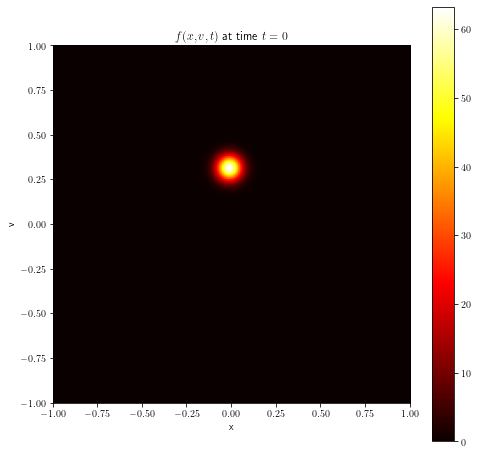

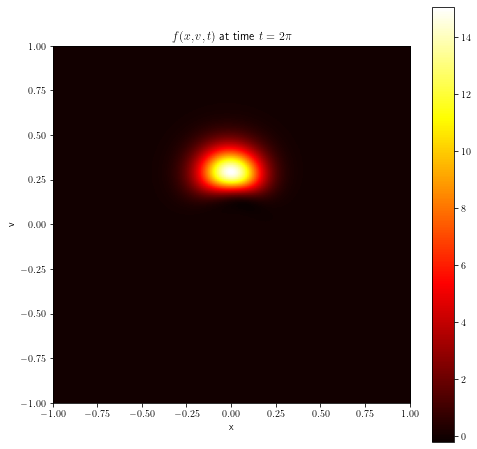

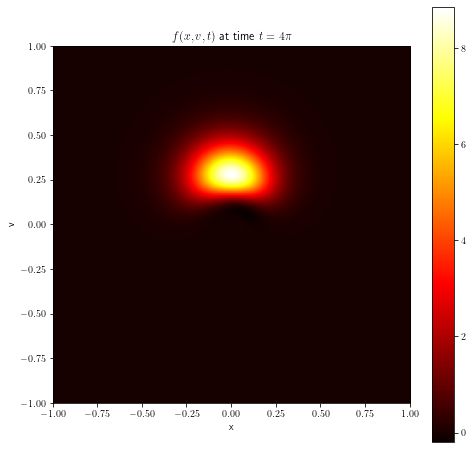

In [ ]:
F = Fo(Xdgrid, Vdgrid)
plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("v")
plt.title(f"$f(x,v,t)$ at time $t = {0}$")
plt.show()
for i in range(1,10):
    F = RK2_integrate(F,K,U, dx, dv, dx*.5, 10*np.pi)[3]
    plt.imshow(F.transpose(), origin = "lower", extent = (-1,1,-1,1), cmap = "hot")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("v")
    plt.title(f"$f(x,v,t)$ at time $t = {2*i}\pi$")
    plt.show()